>[Installation](#scrollTo=hCM9tBkFL2rH)

>[Experiments](#scrollTo=_OSN6uCgMc71)



# Installation

In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    from dgl.nn.pytorch import GraphConv
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    if torch.cuda.is_available(): 
      device = "cuda:0" 
    else:
      device = "cpu" 
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    # if device == "cuda:0":
    #   dgl.seed(seed_value) # dose not work on CPU recently     
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value)) 
    already_installed=True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Node and Edge Featurizer

def atom_is_in_ring_list_one_hot(atom, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [atom.IsInRing()]+[atom.IsInRingSize(i) for i in list]

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

# Almost the same as DMPNN; Not sure about chirlarity
class CanonicalAtomFeaturizer_without_AF_OH(fs.BaseAtomFeaturizer):
    def __init__(self, atom_data_field='h'):
        super().__init__(
            featurizer_funcs={atom_data_field: fs.ConcatFeaturizer(
                [
                 fs.atomic_number_one_hot,
                 fs.atom_degree_one_hot,
                 fs.atom_formal_charge_one_hot,
                 fs.atom_chiral_tag_one_hot,
                 fs.atom_chirality_type_one_hot, 
                 fs.atom_is_chiral_center,
                 fs.atom_total_num_H_one_hot,
                 fs.atom_hybridization_one_hot,
                 fs.atom_is_aromatic,
                 fs.atom_mass,
                 #fs.atom_explicit_valence_one_hot,
                 #fs.atom_implicit_valence_one_hot,                
                 #fs.atom_num_radical_electrons_one_hot,
                 #fs.atom_is_in_ring,
                 #atom_is_in_ring_list_one_hot
                 ]
            )})

# Same as DMPNN
class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 #fs.bond_direction_one_hot,
                 #bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
BondFeaturizer = CanonicalBondFeaturizer()
AtomFeaturizer = CanonicalAtomFeaturizer_without_AF_OH()

In [ ]:
DATA = 'Tox21 - Random Scaffold Split - Seed 213'
# path to datasets
data = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz',compression='gzip').fillna(-1) # replacing NaN values with -1 to be able to create the mask
train = np.load('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/train_smiles', allow_pickle=True)
val = np.load('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/val_smiles', allow_pickle=True)
test = np.load('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/test_smiles', allow_pickle=True)
global_features = pd.read_csv('/content/drive/MyDrive/GMLG_Research/Data/DeepChem_RandomScaffoldSplit/Tox21_seed_213/tox21_global_cdf_rdkit.zip',compression='zip')        
global_features = torch.Tensor(global_features.fillna(global_features.mean()).iloc[:,1:].values) 

In [ ]:
# Building a data generator for each splitted set

class Dataset_generator(torch.utils.data.Dataset): # for Tox21

    def __init__(self, splitted_data, data, gf):

      # In data NaN values are replaced with -1 #

      self.smiles = []
      self.dgl_graphs = []
      self.global_fetures = torch.empty(0)
      self.labels = torch.empty(0)
      self.masks = torch.empty(0)

      self.data_nan_0 = data.where(data != -1, 0) # replacing -1 with 0 for labels, however, it's only neccenary if mask is not used!

      # replacing non NaN values with 1 and NaNs with 0 for mask
      self.data_mask = data.where(data == -1, 1)
      self.data_mask = self.data_mask.where(self.data_mask != -1, 0)

      for i in range(len(splitted_data)):
         
        # finding its id in the main dataset and golbal feature set 
        id = pd.Index(data.smiles).get_loc(splitted_data[i])

        mol =  Chem.MolFromSmiles(splitted_data[i])

        self.smiles.append(splitted_data[i]) 

        self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))

        self.dgl_graphs[i].ndata['h_0'] = AtomFeaturizer(mol)['h'] 

        # for the case encoutring a bondless compound; it can be deal while working on batches of graphs 
        try:
          self.dgl_graphs[i].edata['e_0'] = BondFeaturizer(mol)['e']
        except:
          print(splitted_data[i], "is bondless; I pass")

        self.global_fetures = torch.cat((self.global_fetures, gf[id].view(1,-1)),0)

        self.labels = torch.cat((self.labels, torch.Tensor(self.data_nan_0.iloc[id,:12]).view(1,-1)),0)
        
        self.masks = torch.cat((self.masks, torch.Tensor(self.data_mask.iloc[id,:12]).view(1,-1)),0)

    def __len__(self):

        return len(self.smiles)

    def __getitem__(self, idx):

        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], self.labels[idx], self.masks[idx]

train_set = Dataset_generator(train, data, global_features)
val_set = Dataset_generator(val, data, global_features)
test_set = Dataset_generator(test, data, global_features)


def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader 


RDKit WARNING: [11:33:36] WARNING: not removing hydrogen atom without neighbors


[I-].[K+] is bondless; I pass
[Hg+2] is bondless; I pass
[Ba+2] is bondless; I pass
[TlH2+] is bondless; I pass
[Cr+3] is bondless; I pass
[Fe+2] is bondless; I pass
[Co+2] is bondless; I pass
[PbH2+2] is bondless; I pass
[Fe+3] is bondless; I pass
[Cu+2] is bondless; I pass
[Cd+2] is bondless; I pass
[SnH2+2] is bondless; I pass
[Mn+2] is bondless; I pass
[Be+2] is bondless; I pass
[Zn+2] is bondless; I pass
[Br-].[Na+] is bondless; I pass
[Ca+2].[Cl-].[Cl-] is bondless; I pass
[SbH6+3] is bondless; I pass
[Ni+2] is bondless; I pass


In [ ]:
# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        with torch.no_grad():
          model.eval() #Prepare model for evaluation
          
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
                mol_dgl_graph=mol_dgl_graph.to(device)
                labels=labels.to(device)
                masks=masks.to(device)
                fg=fg.to(device)
                prediction = model(mol_dgl_graph, fg)
                loss_val = my_loss(prediction, labels, masks)
                epoch_val_loss += loss_val.item()
          epoch_val_loss /= (len(val_set))
        
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            average += 100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu'))
            #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) #with pytorch-lightening
            #average += 100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) # with sk-learn
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, masks), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          a1 = prediction_all[:, i][masks_all[:,i]==1]
          a2 = labels_all[:, i][masks_all[:,i]==1]
          results.append(100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu')))
          #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
          #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
          average += results[i]

    print('\n Test AUC is', average.item()/12, '\n Validation Loss is', val_losses[-patience-1])
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs

def train_model_scheduler(model, batch_size, optimizer, scheduler, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_iters = len(train_dataloader)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            scheduler.step(epoch + i / train_iters) #scheduler
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            average += 100*metric(a2.view(-1).to('cpu'), a1.view(-1).to('cpu'))
            #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) #with pytorch-lightening
            #average += 100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) # with sk-learn
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, masks), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          a1 = prediction_all[:, i][masks_all[:,i]==1]
          a2 = labels_all[:, i][masks_all[:,i]==1]
          results.append(100*metric(a2.view(-1).to('cpu'), a1.view(-1).to('cpu')))
          #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
          #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
          average += results[i]

    #print('\n Test AUC is', average.item()/12)
    print('\n Test AUC is', average.item()/12, '\n Validation Loss is', val_losses[-patience-1])
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs 

In [ ]:
def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader 

In [ ]:
%%capture

# class GCN_Module(nn.Module):
#     def __init__(self,
#                  g,
#                  in_dim,
#                  hidden_dim,
#                  out_dim,
#                  n_layers,
#                  activation='relu',
#                  dropout=0):
#         super(GCN, self).__init__()
#         self.g = g
#         self.layers = nn.ModuleList()
#         # input layer
#         self.layers.append(GraphConv(in_dim, hidden_dim, activation=activation))
#         # hidden layers
#         for i in range(n_layers - 1):
#             self.layers.append(GraphConv(hidden_dim, hidden_dim, activation=activation))
#         # output layer
#         self.layers.append(GraphConv(hidden_dim, out_dim))
#         self.dropout = nn.Dropout(p=dropout)

#     def forward(self, features):
#         h = features
#         for i, layer in enumerate(self.layers):
#             if i != 0:
#                 h = self.dropout(h)
#             h = layer(self.g, h)
#         return h

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM_M5(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.g_rep_dim = g_rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers  

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6 
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim) 

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False) 

        # GCN Layer for graph based pooling
        self.GCN1 = GraphConv(self.state_g_dim, self.state_g_dim, activation = F.relu, allow_zero_in_degree = True)
        self.GCN2 = GraphConv(self.state_g_dim, self.state_g_dim, activation = F.relu, allow_zero_in_degree = True) 

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}

    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}


    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['inter_atten'] = self.GCN1(mol_dgl_graph, mol_dgl_graph.ndata['read'])
          
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN2(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten']))
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'rep').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
class DGM_M6(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, read_dim, hidden_read_dim, hidden_g_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", act8="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        self.read_dim = read_dim
        self.hidden_g_dim = hidden_g_dim        
        #self.g_rep_dim = g_rep_dim
        #self.rep_dim = self.state_g_dim
        # self.hidden1_alpha_dim = hidden1_alpha_dim
        # self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers  

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6 
        self.act7 = eval("torch.nn.functional."+act7)
        self.act8 = eval("torch.nn.functional."+act8)


        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        # self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        # self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        # self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        # self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        #self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        self.linear_e_0 = nn.Linear(3*self.state_e_dim + self.feat_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim) 

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.feat_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(self.feat_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.read_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.read_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        # self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        # self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        # self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        # self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        # self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        # self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False) 

        # GCN Layer for graph based pooling
        self.GCN1 = GraphConv(self.read_dim, self.read_dim, activation = F.relu, allow_zero_in_degree = True)
        self.GCN2 = GraphConv(self.read_dim, self.read_dim, activation = F.relu, allow_zero_in_degree = True) 

        self.linear_g_0 = nn.Linear(self.feat_g_dim + self.read_dim, self.hidden_g_dim)
        self.bn_g_0 = nn.BatchNorm1d(self.hidden_g_dim)
        self.linear_g_1 = nn.Linear(self.hidden_g_dim, self.state_g_dim)
        self.bn_g_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        #nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        #nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_g_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_g_1.weight, gain=gain1)
        # nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        # nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        # nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    # def alpha_updater(self,input):

    #   # # It has a depth of 3
    #   # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
    #   # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
    #   # out = self.bn_alpha_2(self.linear_alpha_2(out))
    #   # out = nn.functional.relu(nn.functional.tanh(out))

    #   #print(input)
    #   out = self.act7(self.linear_alpha_0(input))
    #   out = self.act7(self.linear_alpha_1(out))
    #   out = self.linear_alpha_2(out)
    #   out = nn.functional.relu(nn.functional.tanh(out))
    #   #out = nn.functional.relu(out)
    #   #out = 1/2*(nn.functional.tanh(out)+1)
    #   #out = nn.functional.sigmoid(out)

    #   #out = nn.functional.relu(out)
    #   #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
    #   #out = nn.functional.relu(self.linear_alpha_2(out))

    #   return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      #cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}

    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      # hg=torch.empty(0, device=device)
      # hG=torch.empty(0, device=device)
      hg = []
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      #hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))
      hg.append(fg)

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        #mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True) 
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          # mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          # mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          # mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          # mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          # mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['inter_atten'] = self.GCN1(mol_dgl_graph, mol_dgl_graph.ndata['read'])
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN2(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten']))
          rep = dgl.sum_nodes(mol_dgl_graph, 'rep').view(len_batch,-1)
          rep = self.act8(self.bn_g_0(self.linear_g_0(torch.cat((rep, hg[i]),1))))
          hg.append(self.act8(self.bn_g_1(self.linear_g_1(rep))))


          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hg[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

In [ ]:
class DGM_M7(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, message_dim, read_dim, hidden_g_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", act8="relu", num_layers=1):
        super().__init__()

        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        #self.hidden_e_dim = hidden_e_dim
        #self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        #self.hidden_v_dim = hidden_v_dim
        #self.hidden_read_dim = hidden_read_dim
        self.read_dim = read_dim
        self.hidden_g_dim = hidden_g_dim        
        #self.g_rep_dim = g_rep_dim
        #self.rep_dim = self.state_g_dim
        # self.hidden1_alpha_dim = hidden1_alpha_dim
        # self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers  

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6 
        self.act7 = eval("torch.nn.functional."+act7)
        self.act8 = eval("torch.nn.functional."+act8)


        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        # self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        # self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim + 2*self.feat_v_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        # self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        # self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        #self.linear_e_0 = nn.Linear(4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection and without node states (modification)
        self.linear_e_0 = nn.Linear(3*self.state_e_dim + self.feat_g_dim, self.state_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.state_e_dim)
        # self.linear_e_0 = nn.Linear(3*self.state_e_dim + self.feat_g_dim, self.hidden_e_dim)
        # self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        # self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        # self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim) 

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.feat_v_dim + self.state_e_dim, self.m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.m_dim) 
        # self.linear_m_0 = nn.Linear(self.feat_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        # self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        # self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        # self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(self.feat_v_dim + 2*self.m_dim, self.state_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.state_v_dim)
        # self.linear_v_0 = nn.Linear(self.feat_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        # self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        # self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        # self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.read_dim)
        # self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        # self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        # self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.read_dim)
        # self.bn_r_1 = nn.BatchNorm1d(self.read_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        # self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        # self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        # self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        # self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        # self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        # self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False) 

        # GCN Layer for graph based pooling
        self.GCN1 = GraphConv(self.read_dim, self.read_dim, activation = F.relu, allow_zero_in_degree = True)
        self.GCN2 = GraphConv(self.read_dim, self.read_dim, activation = F.relu, allow_zero_in_degree = True) 

        self.linear_g_0 = nn.Linear(self.feat_g_dim + self.read_dim, self.hidden_g_dim)
        self.bn_g_0 = nn.BatchNorm1d(self.hidden_g_dim)
        self.linear_g_1 = nn.Linear(self.hidden_g_dim, self.state_g_dim)
        self.bn_g_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        #nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        #nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        #nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        #nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        #nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        #nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_g_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_g_1.weight, gain=gain1)
        # nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        # nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        # nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    # def alpha_updater(self,input):

    #   # # It has a depth of 3
    #   # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
    #   # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
    #   # out = self.bn_alpha_2(self.linear_alpha_2(out))
    #   # out = nn.functional.relu(nn.functional.tanh(out))

    #   #print(input)
    #   out = self.act7(self.linear_alpha_0(input))
    #   out = self.act7(self.linear_alpha_1(out))
    #   out = self.linear_alpha_2(out)
    #   out = nn.functional.relu(nn.functional.tanh(out))
    #   #out = nn.functional.relu(out)
    #   #out = 1/2*(nn.functional.tanh(out)+1)
    #   #out = nn.functional.sigmoid(out)

    #   #out = nn.functional.relu(out)
    #   #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
    #   #out = nn.functional.relu(self.linear_alpha_2(out))

    #   return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      #out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      #cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      #out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      #out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}

    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      #out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_1(self, edges):

      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    def edges_cat_0(self, edges):

      cat = torch.cat((edges.data['e_0'], edges.src['h_0'], edges.dst['h_0']), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      # hg=torch.empty(0, device=device)
      # hG=torch.empty(0, device=device)
      hg = []
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      #hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))
      hg.append(fg)

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge states
        mol_dgl_graph.apply_edges(self.edges_cat_0)
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["cat"])))

        # Initial node states
        #mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True) 
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat_1)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # Modification can be considered not having the aggregation twice
          # multiplying the new edge states by alpha and their aggregation
          # mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          # mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          # mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          # mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          # mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          mol_dgl_graph.ndata['inter_atten'] = self.GCN1(mol_dgl_graph, mol_dgl_graph.ndata['read'])
          mol_dgl_graph.ndata['rep'] = torch.mul(mol_dgl_graph.ndata['read'], self.GCN2(mol_dgl_graph, mol_dgl_graph.ndata['inter_atten']))
          rep = dgl.sum_nodes(mol_dgl_graph, 'rep').view(len_batch,-1)
          rep = self.act8(self.bn_g_0(self.linear_g_0(torch.cat((rep, hg[i]),1))))
          hg.append(self.act8(self.bn_g_1(self.linear_g_1(rep))))


          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          
          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          #hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hg[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

# Experiments

[ 23/200] Train_Loss: 0.09166 Valid_Loss: 0.23317 Test_AUC: 80.71225
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 453.5291495323181 seconds in cuda:0




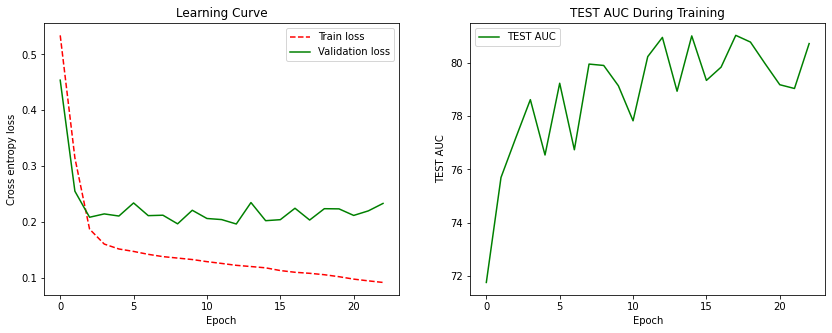


 Test AUC is 80.9436543782552 
 Validation Loss is 0.19632987775108365

 Test AUC in each class is:
(0, 68.10876968922946)
(1, 77.85529715762274)
(2, 86.19823661198237)
(3, 83.38730326078772)
(4, 74.72699321458863)
(5, 82.47272727272727)
(6, 94.43163097199341)
(7, 76.84433621933621)
(8, 78.4)
(9, 80.64516129032259)
(10, 86.4210721917681)
(11, 81.83224755700326)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M7(135,12,200,100,100,100,100,100,100,num_layers=1)
        self.GNN2 = DGM_M7(100,100,100,80,80,80,80,80,80,num_layers=1)
        self.linear_1 = nn.Linear(80, 60)
        self.linear_2 = nn.Linear(60, 12)
        #self.bn = nn.BatchNorm1d(100)
        self.bn1 = nn.BatchNorm1d(60)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)
# count_parameters(model)

[ 21/200] Train_Loss: 0.09697 Valid_Loss: 0.22632 Test_AUC: 78.54779
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 409.625803232193 seconds in cuda:0




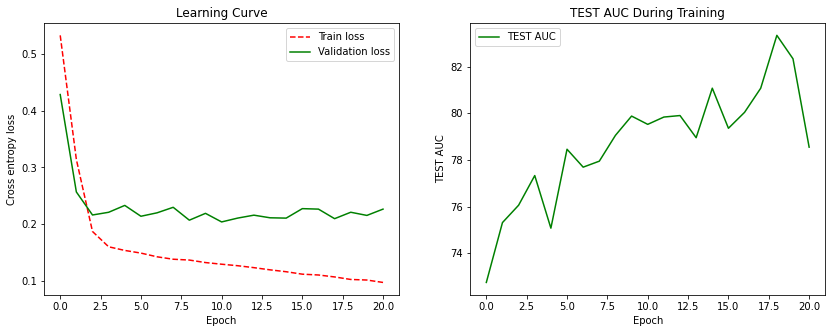


 Test AUC is 79.52543131510417 
 Validation Loss is 0.2037213600762807

 Test AUC in each class is:
(0, 66.38995317156238)
(1, 86.31782945736435)
(2, 85.4285611042856)
(3, 78.35680397620303)
(4, 73.23738337574216)
(5, 75.38787878787879)
(6, 92.92696320702912)
(7, 77.5094696969697)
(8, 73.10676691729324)
(9, 81.31904551480336)
(10, 86.8531078695531)
(11, 77.47149837133551)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M7(135,12,200,100,100,100,100,100,100,num_layers=1)
        self.GNN2 = DGM_M7(100,100,100,80,80,80,80,80,80,num_layers=1)
        self.linear_1 = nn.Linear(80, 60)
        self.linear_2 = nn.Linear(60, 12)
        #self.bn = nn.BatchNorm1d(100)
        self.bn1 = nn.BatchNorm1d(60)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)
# count_parameters(model)

[ 21/200] Train_Loss: 0.09434 Valid_Loss: 0.22526 Test_AUC: 79.46199
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 413.568008184433 seconds in cuda:0




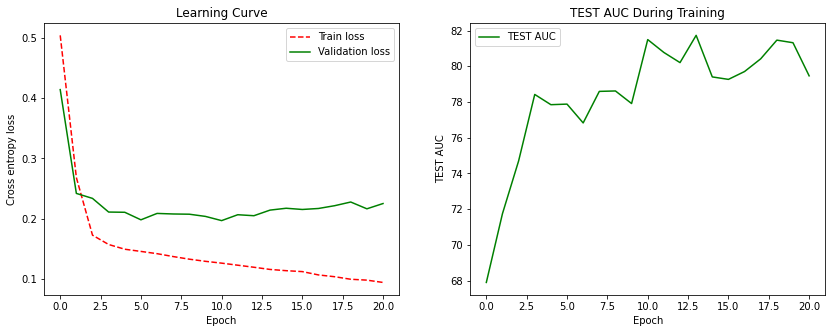


 Test AUC is 81.49110412597656 
 Validation Loss is 0.1969270730536255

 Test AUC in each class is:
(0, 65.92166879523201)
(1, 82.58397932816538)
(2, 85.5405796054058)
(3, 84.4453648618119)
(4, 72.85040288379983)
(5, 80.0)
(6, 90.40087863811092)
(7, 82.0842352092352)
(8, 80.16842105263157)
(9, 79.61224038886434)
(10, 89.0574189352411)
(11, 85.22801302931596)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M7(135,12,200,100,100,100,100,100,100,num_layers=1)
        self.GNN2 = DGM_M7(100,100,100,100,100,100,100,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(100)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)
# count_parameters(model)

[ 39/200] Train_Loss: 0.04733 Valid_Loss: 0.30577 Test_AUC: 78.39308
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 687.6384630203247 seconds in cuda:0




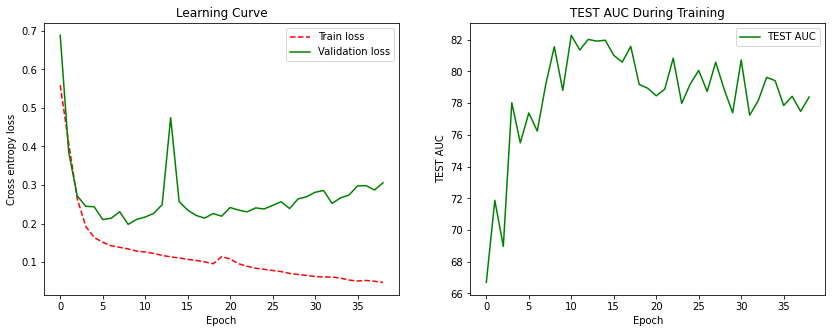


 Test AUC is 81.56170654296875 
 Validation Loss is 0.19789170153144067

 Test AUC in each class is:
(0, 68.1406981694338)
(1, 84.03100775193798)
(2, 84.51253884512539)
(3, 85.38670080578356)
(4, 74.22603901611535)
(5, 85.03636363636365)
(6, 89.99450851180671)
(7, 79.56349206349206)
(8, 77.19699248120301)
(9, 79.3194874060981)
(10, 88.44188423302053)
(11, 82.89087947882736)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=30, n_epochs=200)
print(DATA)

[ 16/200] Train_Loss: 0.11953 Valid_Loss: 0.20611 Test_AUC: 79.96148
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 369.8626525402069 seconds in cuda:0




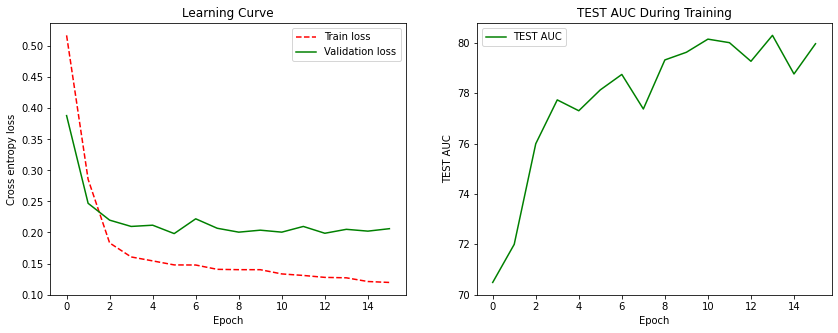


 Test AUC is 78.12939961751302 
 Validation Loss is 0.19821416007147896

 Test AUC in each class is:
(0, 59.01447424435929)
(1, 77.14470284237727)
(2, 85.33099660330996)
(3, 79.1023420438286)
(4, 74.81711195928753)
(5, 79.23636363636363)
(6, 86.88632619439869)
(7, 74.40476190476191)
(8, 76.2406015037594)
(9, 78.10428634555899)
(10, 85.83341075908204)
(11, 81.43729641693811)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M7(135,12,200,100,100,100,100,100,100,num_layers=1)
        self.GNN2 = DGM_M7(100,100,100,100,100,100,100,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(100)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)
# count_parameters(model)

In [ ]:
DGM_M7(135,12,200,100,100,100,100,100,100,num_layers=1)

In [ ]:
MH = MPNN(161, 320, 19, 38)
M7 = DGM_M7(135,12,200,300,300,300,300,300,300,num_layers=1)
M6 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
M5 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)

In [ ]:
count_parameters(M7)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| linear_0_e.weight |   28200    |
|  linear_0_e.bias  |    100     |
|   bn_0_e.weight   |    100     |
|    bn_0_e.bias    |    100     |
| linear_e_0.weight |   50000    |
|  linear_e_0.bias  |    100     |
|   bn_e_0.weight   |    100     |
|    bn_e_0.bias    |    100     |
| linear_m_0.weight |   23500    |
|   bn_m_0.weight   |    100     |
|    bn_m_0.bias    |    100     |
| linear_v_0.weight |   33500    |
|  linear_v_0.bias  |    100     |
|   bn_v_0.weight   |    100     |
|    bn_v_0.bias    |    100     |
| linear_r_0.weight |   30000    |
|  linear_r_0.bias  |    100     |
|   bn_r_0.weight   |    100     |
|    bn_r_0.bias    |    100     |
|    GCN1.weight    |   10000    |
|     GCN1.bias     |    100     |
|    GCN2.weight    |   10000    |
|     GCN2.bias     |    100     |
| linear_g_0.weight |   30000    |
|  linear_g_0.bias  |    100     |
|   bn_g_0.weight   

227400

In [ ]:
M7 = DGM_M7(135,12,200,300,300,300,300,300,300,300,num_layers=1)

In [ ]:
count_parameters(MH)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|    bn_v.weight    |    320     |
|     bn_v.bias     |    320     |
|    bn_e.weight    |     38     |
|     bn_e.bias     |     38     |
| linear_v_1.weight |   51520    |
|  linear_v_1.bias  |    320     |
|  linear_e.weight  |   12882    |
|   linear_e.bias   |     38     |
+-------------------+------------+
Total Trainable Params: 65476


65476

In [ ]:
count_parameters(M6)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| linear_0_e.weight |   84600    |
|  linear_0_e.bias  |    300     |
|   bn_0_e.weight   |    300     |
|    bn_0_e.bias    |    300     |
| linear_e_0.weight |   330000   |
|  linear_e_0.bias  |    300     |
|   bn_e_0.weight   |    300     |
|    bn_e_0.bias    |    300     |
| linear_e_1.weight |   90000    |
|  linear_e_1.bias  |    300     |
|   bn_e_1.weight   |    300     |
|    bn_e_1.bias    |    300     |
| linear_m_0.weight |   130500   |
|   bn_m_0.weight   |    300     |
|    bn_m_0.bias    |    300     |
| linear_m_1.weight |   90000    |
|   bn_m_1.weight   |    300     |
|    bn_m_1.bias    |    300     |
| linear_v_0.weight |   220500   |
|  linear_v_0.bias  |    300     |
|   bn_v_0.weight   |    300     |
|    bn_v_0.bias    |    300     |
| linear_v_1.weight |   90000    |
|  linear_v_1.bias  |    300     |
|   bn_v_1.weight   |    300     |
|    bn_v_1.bias    

1825500

In [ ]:
count_parameters(M5)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|   linear_0_v.weight   |   40500    |
|    linear_0_v.bias    |    300     |
|     bn_0_v.weight     |    300     |
|      bn_0_v.bias      |    300     |
|   linear_0_e.weight   |   84600    |
|    linear_0_e.bias    |    300     |
|     bn_0_e.weight     |    300     |
|      bn_0_e.bias      |    300     |
|   linear_0_g.weight   |   60000    |
|    linear_0_g.bias    |    300     |
|     bn_0_g.weight     |    300     |
|      bn_0_g.bias      |    300     |
|   linear_e_0.weight   |   450000   |
|    linear_e_0.bias    |    300     |
|     bn_e_0.weight     |    300     |
|      bn_e_0.bias      |    300     |
|   linear_e_1.weight   |   90000    |
|    linear_e_1.bias    |    300     |
|     bn_e_1.weight     |    300     |
|      bn_e_1.bias      |    300     |
|   linear_m_0.weight   |   180000   |
|     bn_m_0.weight     |    300     |
|      bn_m_0.bias      |

1998605

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
#model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=4)
print(DATA)
count_parameters(model)

Tox21 - Random Scaffold Split - Seed 213
+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| GNN1.linear_0_e.weight |   84600    |
|  GNN1.linear_0_e.bias  |    300     |
|   GNN1.bn_0_e.weight   |    300     |
|    GNN1.bn_0_e.bias    |    300     |
| GNN1.linear_e_0.weight |   330000   |
|  GNN1.linear_e_0.bias  |    300     |
|   GNN1.bn_e_0.weight   |    300     |
|    GNN1.bn_e_0.bias    |    300     |
| GNN1.linear_e_1.weight |   90000    |
|  GNN1.linear_e_1.bias  |    300     |
|   GNN1.bn_e_1.weight   |    300     |
|    GNN1.bn_e_1.bias    |    300     |
| GNN1.linear_m_0.weight |   130500   |
|   GNN1.bn_m_0.weight   |    300     |
|    GNN1.bn_m_0.bias    |    300     |
| GNN1.linear_m_1.weight |   90000    |
|   GNN1.bn_m_1.weight   |    300     |
|    GNN1.bn_m_1.bias    |    300     |
| GNN1.linear_v_0.weight |   220500   |
|  GNN1.linear_v_0.bias  |    300     |
|   GNN1.bn_v_0.weight   |    300     |

2953612

[4/4] Train_Loss: 0.16070 Valid_Loss: 0.22315 Test_AUC: 74.61555
Validation loss decreased (0.257581 --> 0.223155).  Saving model ...

 Training Time was 423.4523813724518 seconds in cpu




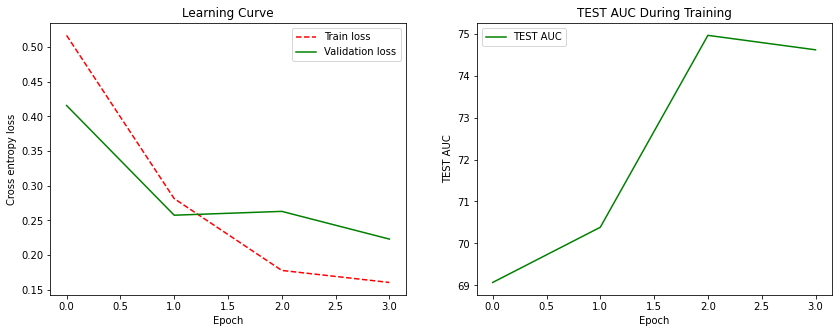

IndexError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=4)
# print(DATA)
# count_parameters(model)

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)
print(DATA)
count_parameters(model)

Tox21 - Random Scaffold Split - Seed 213
+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| GNN1.linear_0_e.weight |   84600    |
|  GNN1.linear_0_e.bias  |    300     |
|   GNN1.bn_0_e.weight   |    300     |
|    GNN1.bn_0_e.bias    |    300     |
| GNN1.linear_e_0.weight |   330000   |
|  GNN1.linear_e_0.bias  |    300     |
|   GNN1.bn_e_0.weight   |    300     |
|    GNN1.bn_e_0.bias    |    300     |
| GNN1.linear_e_1.weight |   90000    |
|  GNN1.linear_e_1.bias  |    300     |
|   GNN1.bn_e_1.weight   |    300     |
|    GNN1.bn_e_1.bias    |    300     |
| GNN1.linear_m_0.weight |   130500   |
|   GNN1.bn_m_0.weight   |    300     |
|    GNN1.bn_m_0.bias    |    300     |
| GNN1.linear_m_1.weight |   90000    |
|   GNN1.bn_m_1.weight   |    300     |
|    GNN1.bn_m_1.bias    |    300     |
| GNN1.linear_v_0.weight |   220500   |
|  GNN1.linear_v_0.bias  |    300     |
|   GNN1.bn_v_0.weight   |    300     |

2953612

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)
print(DATA)

Tox21 - Random Scaffold Split - Seed 213


In [ ]:
count_parameters(model)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| GNN1.linear_0_e.weight |   84600    |
|  GNN1.linear_0_e.bias  |    300     |
|   GNN1.bn_0_e.weight   |    300     |
|    GNN1.bn_0_e.bias    |    300     |
| GNN1.linear_e_0.weight |   330000   |
|  GNN1.linear_e_0.bias  |    300     |
|   GNN1.bn_e_0.weight   |    300     |
|    GNN1.bn_e_0.bias    |    300     |
| GNN1.linear_e_1.weight |   90000    |
|  GNN1.linear_e_1.bias  |    300     |
|   GNN1.bn_e_1.weight   |    300     |
|    GNN1.bn_e_1.bias    |    300     |
| GNN1.linear_m_0.weight |   130500   |
|   GNN1.bn_m_0.weight   |    300     |
|    GNN1.bn_m_0.bias    |    300     |
| GNN1.linear_m_1.weight |   90000    |
|   GNN1.bn_m_1.weight   |    300     |
|    GNN1.bn_m_1.bias    |    300     |
| GNN1.linear_v_0.weight |   220500   |
|  GNN1.linear_v_0.bias  |    300     |
|   GNN1.bn_v_0.weight   |    300     |
|    GNN1.bn_v_0.bias    |    300     |


2953612

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model1 = GNN().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=30, n_epochs=200)
print(DATA)

Tox21 - Random Scaffold Split - Seed 213


In [ ]:
count_parameters(model1)

+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   40500    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |   84600    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   450000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |
|      GNN1.bn_e_1.bias      |  

3129122

[1/1] Train_Loss: 0.51790 Valid_Loss: 0.39490 Test_AUC: 69.57127
Validation loss decreased (inf --> 0.394899).  Saving model ...

 Training Time was 17.854795455932617 seconds in cuda:0




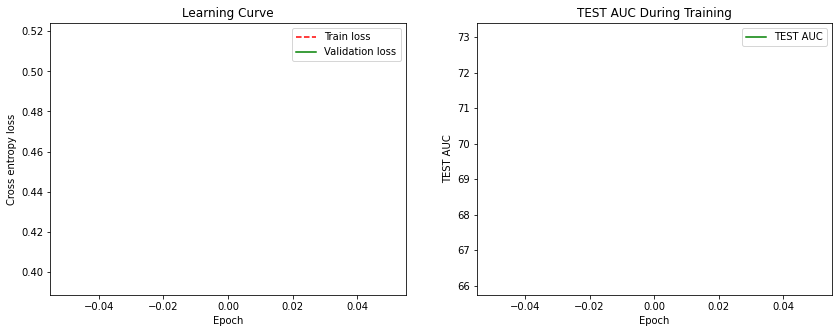

IndexError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)
print(DATA)

[1/1] Train_Loss: 0.51877 Valid_Loss: 0.41784 Test_AUC: 69.43194
Validation loss decreased (inf --> 0.417835).  Saving model ...

 Training Time was 17.826769590377808 seconds in cuda:0




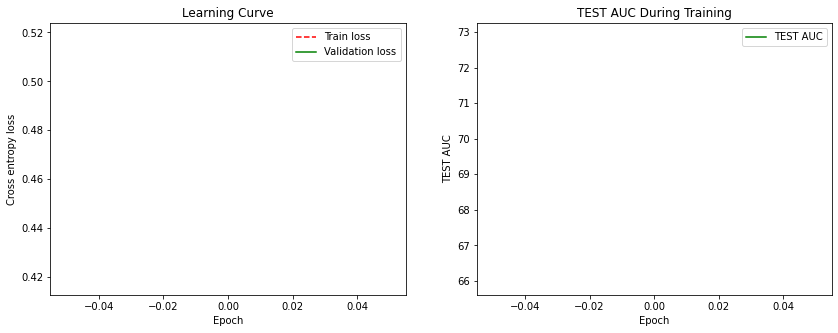

IndexError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)
print(DATA)

[ 22/200] Train_Loss: 0.10661 Valid_Loss: 0.21503 Test_AUC: 79.13840
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 358.4206039905548 seconds in cuda:0




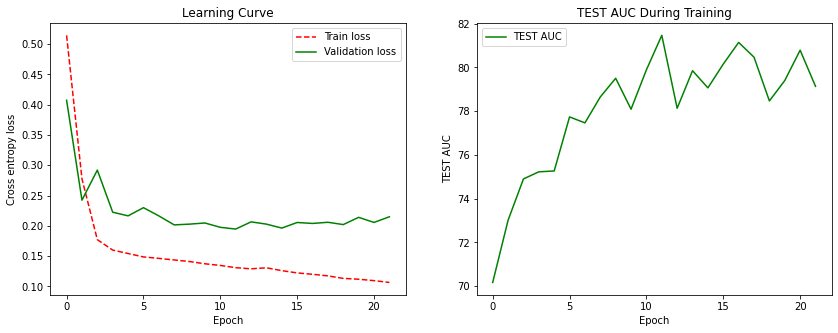


 Test AUC is 81.46931457519531 
 Validation Loss is 0.19471589206583503

 Test AUC in each class is:
(0, 71.74861643252447)
(1, 80.50387596899226)
(2, 86.57584736575848)
(3, 81.36531365313654)
(4, 76.50021204410517)
(5, 80.80000000000001)
(6, 91.01592531576057)
(7, 77.26145382395383)
(8, 78.51428571428572)
(9, 80.31926646045072)
(10, 88.21425253182198)
(11, 84.81270358306188)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 21/200] Train_Loss: 0.11115 Valid_Loss: 0.20584 Test_AUC: 78.54743
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 348.37570571899414 seconds in cuda:0




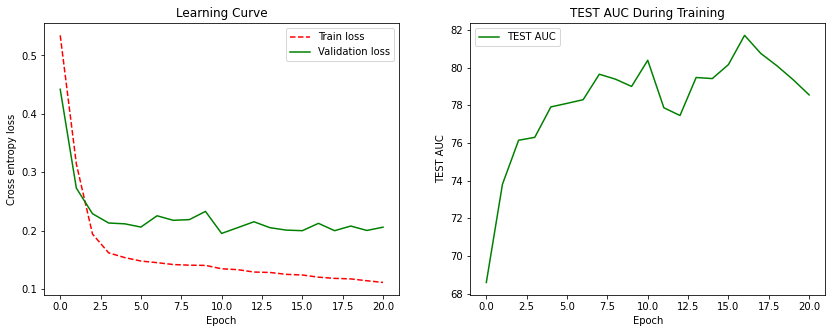


 Test AUC is 80.38456217447917 
 Validation Loss is 0.19514257423722425

 Test AUC in each class is:
(0, 63.484461472967226)
(1, 82.2609819121447)
(2, 85.16658235166582)
(3, 81.84727765645003)
(4, 73.76749363867684)
(5, 78.97575757575758)
(6, 91.3454146073586)
(7, 79.27489177489177)
(8, 76.93834586466166)
(9, 81.47923110914715)
(10, 87.1875871039673)
(11, 82.88680781758958)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.GNN2 = DGM_M6(200,200,200,100,100,100,100,100,100,100,100,100,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)
#count_parameters(model)

In [ ]:
model1 = model

[ 11/200] Train_Loss: 0.09208 Valid_Loss: 0.20136 Test_AUC: 80.52288
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 150.36918377876282 seconds in cuda:0




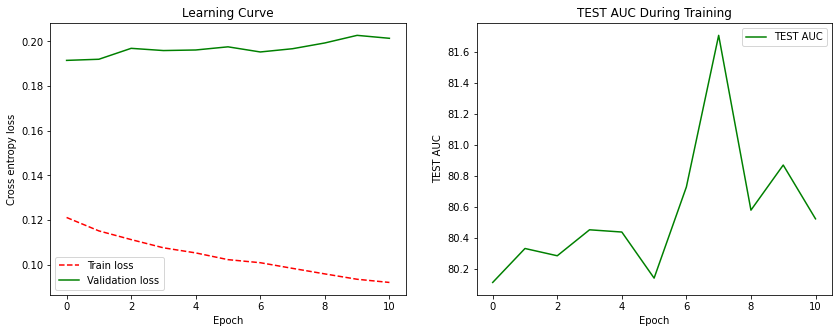


 Test AUC is 80.11256917317708 
 Validation Loss is 0.19147605518423888

 Test AUC in each class is:
(0, 63.010855683269476)
(1, 83.92764857881137)
(2, 84.18190359181904)
(3, 79.65961292265985)
(4, 71.56488549618321)
(5, 78.3030303030303)
(6, 92.20208676551344)
(7, 76.6301406926407)
(8, 79.41052631578947)
(9, 79.57357490057446)
(10, 87.65446436867045)
(11, 85.23208469055375)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model2 = model

[ 13/200] Train_Loss: 0.11266 Valid_Loss: 0.19590 Test_AUC: 79.99307
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 215.22757959365845 seconds in cuda:0




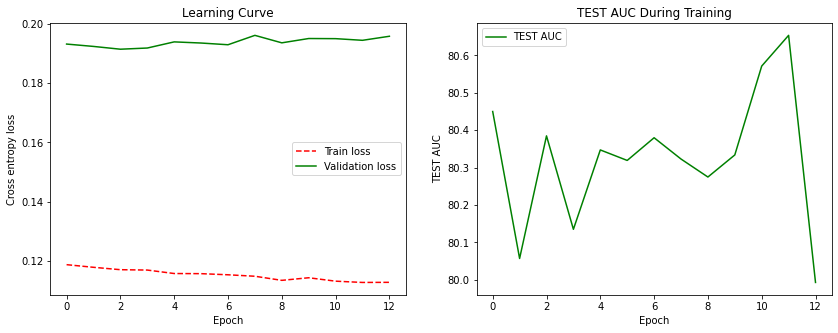


 Test AUC is 80.38480631510417 
 Validation Loss is 0.19152438808066025

 Test AUC in each class is:
(0, 65.30970625798213)
(1, 84.53488372093022)
(2, 84.99674784996748)
(3, 79.66337826643573)
(4, 72.4740245971162)
(5, 78.33939393939394)
(6, 92.7951674903899)
(7, 76.76542207792208)
(8, 78.89323308270677)
(9, 77.23155103844455)
(10, 88.0725634116882)
(11, 85.5415309446254)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 13/200] Train_Loss: 0.10491 Valid_Loss: 0.19178 Test_AUC: 80.64916
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 164.19284653663635 seconds in cuda:0




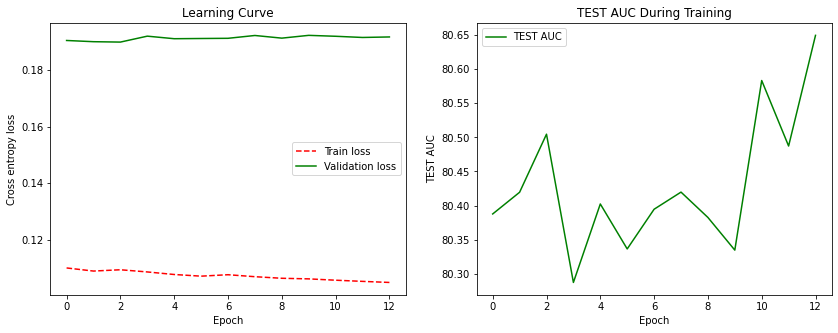


 Test AUC is 80.50457255045573 
 Validation Loss is 0.18995817167396595

 Test AUC in each class is:
(0, 63.782460621541084)
(1, 84.49612403100775)
(2, 84.95157909951578)
(3, 80.83063483696061)
(4, 71.82198897370652)
(5, 77.62424242424242)
(6, 92.8390993959363)
(7, 76.8916847041847)
(8, 79.10977443609023)
(9, 79.34710561201945)
(10, 88.49298522716714)
(11, 85.86726384364822)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model3 = model

[ 14/200] Train_Loss: 0.10354 Valid_Loss: 0.19204 Test_AUC: 80.56437
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 164.19474577903748 seconds in cuda:0




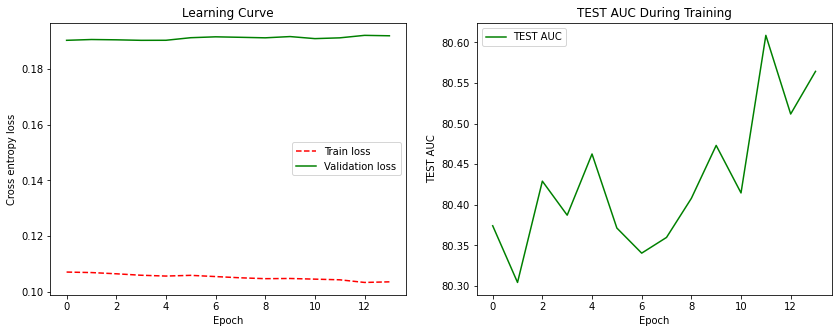


 Test AUC is 80.38730367024739 
 Validation Loss is 0.19040040068547234

 Test AUC in each class is:
(0, 63.67603235419328)
(1, 85.10335917312662)
(2, 84.9949410999494)
(3, 80.7779200240982)
(4, 71.81403731976252)
(5, 77.55151515151516)
(6, 92.6963207029105)
(7, 76.41819985569985)
(8, 78.92932330827067)
(9, 78.5461776403005)
(10, 88.50459908947319)
(11, 85.63517915309447)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=200)

[ 13/200] Train_Loss: 0.12303 Valid_Loss: 0.20106 Test_AUC: 80.79369
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 300.0198607444763 seconds in cuda:0




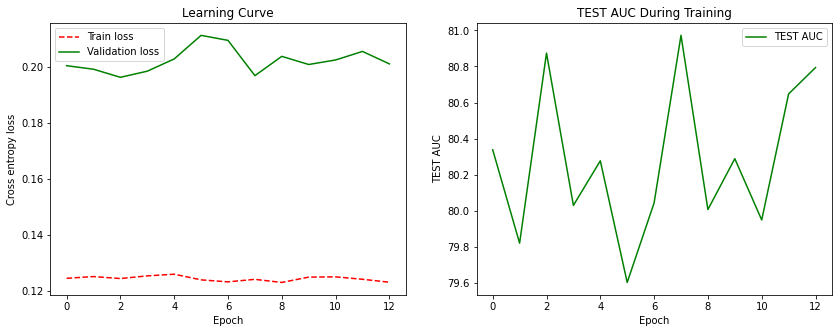


 Test AUC is 80.87372334798177 
 Validation Loss is 0.19627594247479396

 Test AUC in each class is:
(0, 69.91272882077479)
(1, 83.91472868217055)
(2, 85.02204235022043)
(3, 83.62451991866857)
(4, 71.7636768447837)
(5, 78.18787878787879)
(6, 91.88358045030202)
(7, 77.14195526695526)
(8, 78.68872180451127)
(9, 76.61290322580643)
(10, 88.23515748397288)
(11, 85.49674267100977)


In [ ]:
model =  model3
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=16, optimizer=optimizer, patience=10, n_epochs=200)

[ 21/200] Train_Loss: 0.10509 Valid_Loss: 0.21418 Test_AUC: 78.48830
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 349.4608905315399 seconds in cuda:0




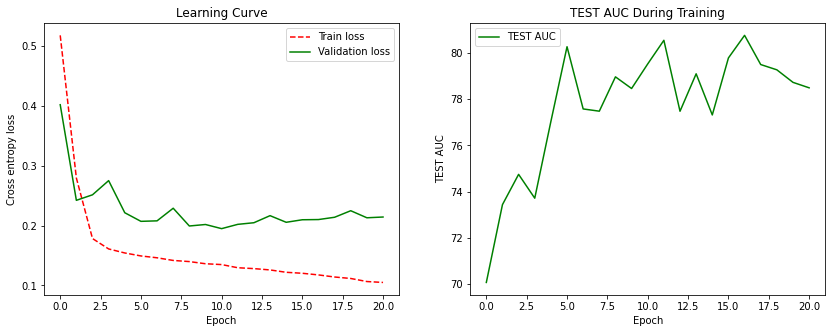


 Test AUC is 79.52079772949219 
 Validation Loss is 0.1947947720762718

 Test AUC in each class is:
(0, 68.11941251596423)
(1, 79.8966408268734)
(2, 85.17742285177422)
(3, 80.31478273966412)
(4, 72.64631043256998)
(5, 81.10909090909091)
(6, 89.53322350356947)
(7, 74.48818542568543)
(8, 74.70676691729322)
(9, 76.62947414935925)
(10, 87.01105639691536)
(11, 84.6172638436482)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 19/200] Train_Loss: 0.11128 Valid_Loss: 0.21243 Test_AUC: 77.88684
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 316.77450704574585 seconds in cuda:0




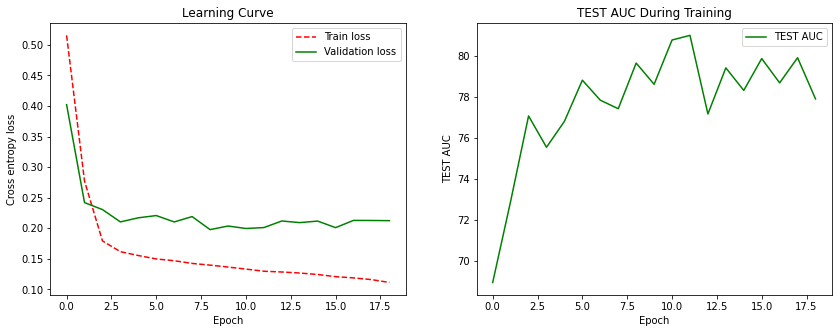


 Test AUC is 79.63377380371094 
 Validation Loss is 0.1977221429880856

 Test AUC in each class is:
(0, 60.93018305661984)
(1, 86.35658914728683)
(2, 85.87302160873021)
(3, 76.37246780631072)
(4, 75.02650551314673)
(5, 79.55151515151515)
(6, 90.90609555189457)
(7, 73.19624819624819)
(8, 76.72781954887218)
(9, 79.38577110030933)
(10, 85.04134534980955)
(11, 86.23778501628664)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 20/200] Train_Loss: 0.10943 Valid_Loss: 0.22014 Test_AUC: 79.75479
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 333.88050985336304 seconds in cuda:0




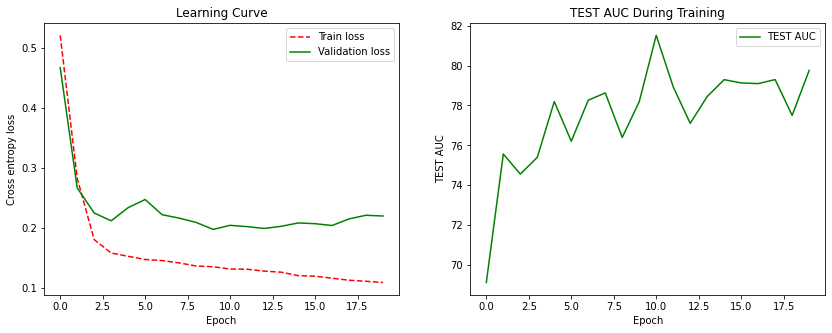


 Test AUC is 78.19076538085938 
 Validation Loss is 0.19784974930082397

 Test AUC in each class is:
(0, 55.30012771392082)
(1, 81.02067183462532)
(2, 84.84136734841368)
(3, 78.97808569922434)
(4, 71.54368108566582)
(5, 76.7939393939394)
(6, 89.08292147171885)
(7, 79.15990259740259)
(8, 74.71278195488722)
(9, 79.83870967741935)
(10, 84.48852550404162)
(11, 82.5285016286645)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

# seed_value= 1 
# random.seed(seed_value)
# np.random.seed(seed_value)
# torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 19/200] Train_Loss: 0.10139 Valid_Loss: 0.22123 Test_AUC: 80.19448
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 337.93424558639526 seconds in cuda:0




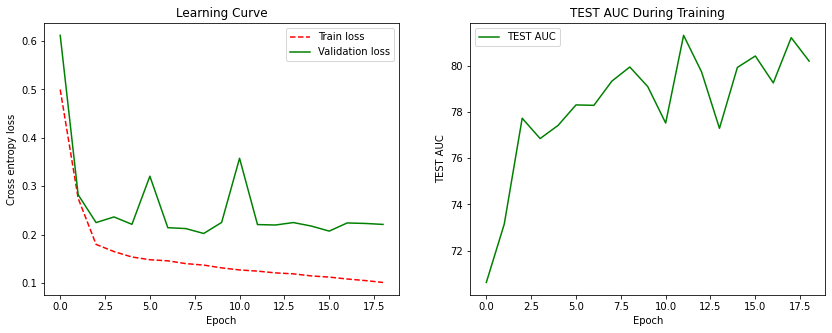


 Test AUC is 79.94028727213542 
 Validation Loss is 0.20250616280664124

 Test AUC in each class is:
(0, 72.96988080034058)
(1, 80.99483204134367)
(2, 83.72931271229314)
(3, 79.09481135627684)
(4, 72.2328244274809)
(5, 80.13333333333334)
(6, 89.34651290499727)
(7, 75.85001803751804)
(8, 77.17593984962406)
(9, 78.24790101634999)
(10, 86.40945832946205)
(11, 83.0985342019544)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

In [ ]:
count_parameters(model)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| GNN1.linear_0_e.weight |   84600    |
|  GNN1.linear_0_e.bias  |    300     |
|   GNN1.bn_0_e.weight   |    300     |
|    GNN1.bn_0_e.bias    |    300     |
| GNN1.linear_e_0.weight |   330000   |
|  GNN1.linear_e_0.bias  |    300     |
|   GNN1.bn_e_0.weight   |    300     |
|    GNN1.bn_e_0.bias    |    300     |
| GNN1.linear_e_1.weight |   90000    |
|  GNN1.linear_e_1.bias  |    300     |
|   GNN1.bn_e_1.weight   |    300     |
|    GNN1.bn_e_1.bias    |    300     |
| GNN1.linear_m_0.weight |   130500   |
|   GNN1.bn_m_0.weight   |    300     |
|    GNN1.bn_m_0.bias    |    300     |
| GNN1.linear_m_1.weight |   90000    |
|   GNN1.bn_m_1.weight   |    300     |
|    GNN1.bn_m_1.bias    |    300     |
| GNN1.linear_v_0.weight |   220500   |
|  GNN1.linear_v_0.bias  |    300     |
|   GNN1.bn_v_0.weight   |    300     |
|    GNN1.bn_v_0.bias    |    300     |


2813715

In [ ]:
from torch.nn import MultiheadAttention

In [ ]:
embed_dim = 10 
num_heads = 10

In [ ]:
>>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
>>> attn_output, attn_output_weights = multihead_attn(query, key, value)

NameError: ignored

In [ ]:

# seed_value= 1 
# random.seed(seed_value)
# np.random.seed(seed_value)
# torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M6(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M6(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg): 
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output) 
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

RuntimeError: ignored

[ 18/200] Train_Loss: 0.09905 Valid_Loss: 0.22758 Test_AUC: 76.78288
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 563.3847146034241 seconds in cuda:0




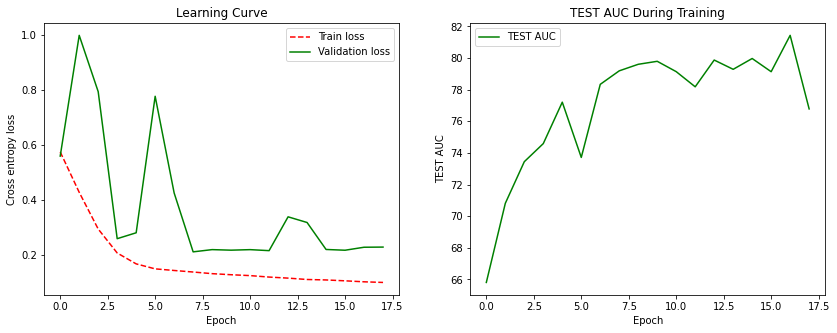


 Test AUC is 79.1898905436198 
 Validation Loss is 0.21027081496870836

 Test AUC in each class is:
(0, 58.55151128139633)
(1, 87.81653746770026)
(2, 79.35065404350654)
(3, 77.61126590857744)
(4, 77.04755089058524)
(5, 82.53939393939393)
(6, 88.00658978583196)
(7, 76.95932539682539)
(8, 73.43157894736842)
(9, 77.75077330976579)
(10, 87.76479606057791)
(11, 83.4486970684039)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

# seed_value= 1 
# random.seed(seed_value)
# np.random.seed(seed_value)
# torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 22/200] Train_Loss: 0.08724 Valid_Loss: 0.25477 Test_AUC: 77.45028
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 686.9761595726013 seconds in cuda:0




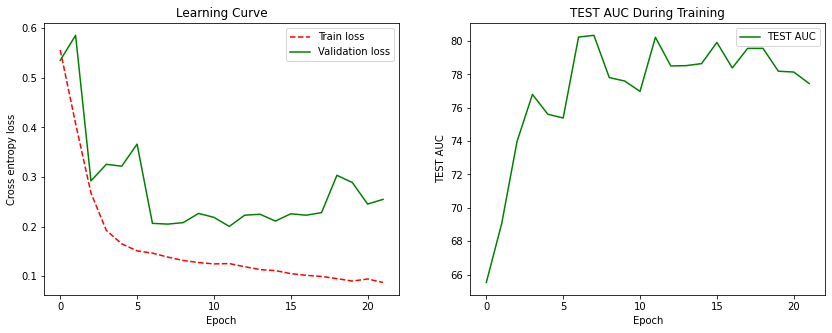


 Test AUC is 80.22032165527344 
 Validation Loss is 0.2002382101836028

 Test AUC in each class is:
(0, 59.37633035334184)
(1, 80.83979328165375)
(2, 87.55691262556913)
(3, 82.12967843964154)
(4, 73.53689567430027)
(5, 83.2969696969697)
(6, 89.62108731466228)
(7, 78.92766955266956)
(8, 77.67819548872181)
(9, 79.78347326557666)
(10, 86.88794945647125)
(11, 83.00895765472312)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

# seed_value= 1 
# random.seed(seed_value)
# np.random.seed(seed_value)
# torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 15/200] Train_Loss: 0.11032 Valid_Loss: 0.22861 Test_AUC: 78.38714
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 467.59181666374207 seconds in cuda:0




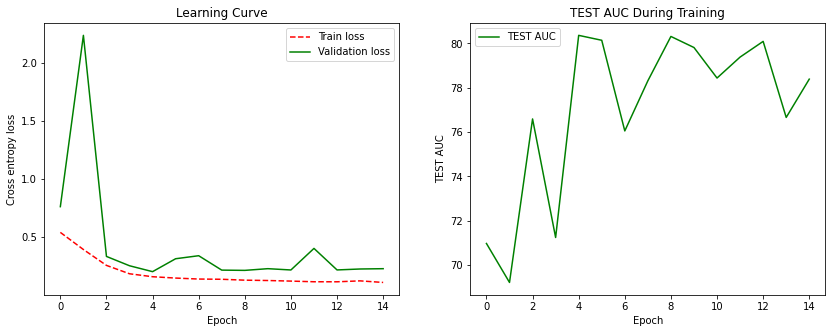


 Test AUC is 80.36385599772136 
 Validation Loss is 0.20310051687832537

 Test AUC in each class is:
(0, 70.14154959557258)
(1, 83.81136950904393)
(2, 83.04003758040038)
(3, 81.09797424504856)
(4, 73.69592875318067)
(5, 81.44848484848485)
(6, 82.7018121911038)
(7, 77.36742424242425)
(8, 80.03007518796991)
(9, 80.30269553689793)
(10, 85.33401467992196)
(11, 85.39495114006515)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

# seed_value= 1 
# random.seed(seed_value)
# np.random.seed(seed_value)
# torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 39/200] Train_Loss: 0.04770 Valid_Loss: 0.30266 Test_AUC: 80.09464
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 1225.2221970558167 seconds in cuda:0




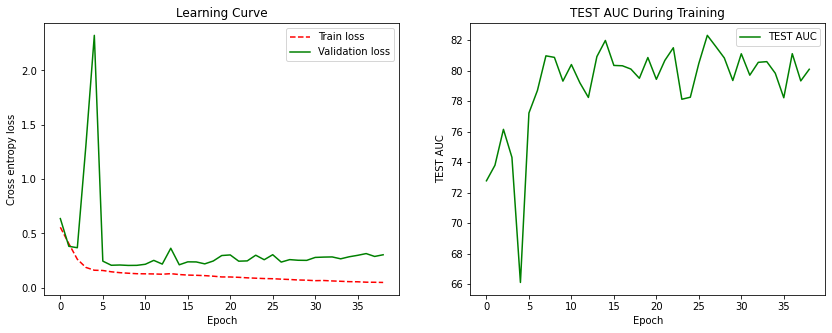


 Test AUC is 80.87588500976562 
 Validation Loss is 0.20445908501382684

 Test AUC in each class is:
(0, 66.3101319710515)
(1, 82.70025839793281)
(2, 85.34364385343643)
(3, 84.58844792529557)
(4, 76.1503392705683)
(5, 85.34545454545454)
(6, 91.66392092257001)
(7, 74.77678571428572)
(8, 81.84661654135338)
(9, 73.42576226248343)
(10, 85.66384836941373)
(11, 82.69543973941369)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=30, n_epochs=200)
print(DATA)

[ 19/200] Train_Loss: 0.10107 Valid_Loss: 0.21054 Test_AUC: 79.88585
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 601.9560985565186 seconds in cuda:0




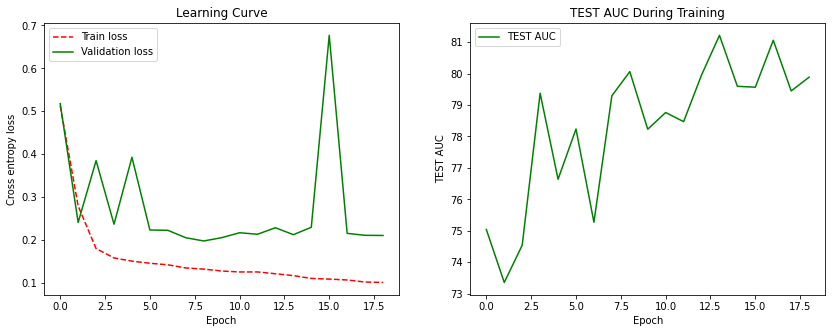


 Test AUC is 80.06200154622395 
 Validation Loss is 0.19773715209230153

 Test AUC in each class is:
(0, 63.213069391230306)
(1, 82.5452196382429)
(2, 82.99667557996676)
(3, 84.21567889148278)
(4, 71.5754877014419)
(5, 80.15151515151516)
(6, 88.81933003844043)
(7, 75.89060245310246)
(8, 82.50827067669174)
(9, 78.75607600530272)
(10, 86.52559695252255)
(11, 83.54641693811075)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 19/200] Train_Loss: 0.08441 Valid_Loss: 0.25143 Test_AUC: 78.34932
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 506.25888538360596 seconds in cuda:0




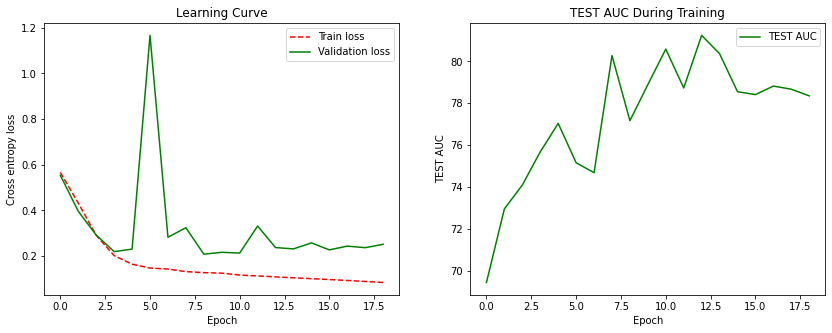


 Test AUC is 77.1649169921875 
 Validation Loss is 0.2082247252969754

 Test AUC in each class is:
(0, 62.808641975308646)
(1, 68.81136950904393)
(2, 80.07696755076967)
(3, 83.1350252278033)
(4, 74.4407336726039)
(5, 79.23636363636363)
(6, 89.50027457440967)
(7, 77.85218253968253)
(8, 76.34285714285714)
(9, 69.40455148033585)
(10, 82.6395986249187)
(11, 81.73045602605863)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 19/200] Train_Loss: 0.09708 Valid_Loss: 0.21948 Test_AUC: 81.12302
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 598.6814720630646 seconds in cuda:0




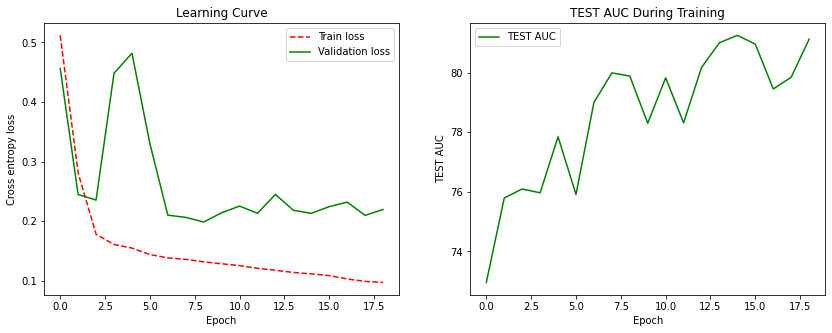


 Test AUC is 79.8846435546875 
 Validation Loss is 0.19850999855294843

 Test AUC in each class is:
(0, 61.7762877820349)
(1, 86.80878552971576)
(2, 82.63351882633518)
(3, 87.55553882069434)
(4, 72.28318490245971)
(5, 77.64242424242424)
(6, 87.52333882482152)
(7, 78.59172077922078)
(8, 77.89473684210526)
(9, 74.97790543526294)
(10, 87.87048220756294)
(11, 83.05781758957654)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 16/200] Train_Loss: 0.09132 Valid_Loss: 0.26639 Test_AUC: 80.81595
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 263.3496470451355 seconds in cuda:0




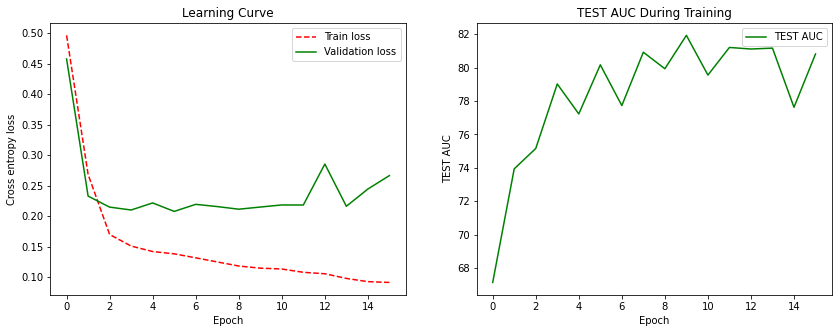


 Test AUC is 80.16806538899739 
 Validation Loss is 0.20769998336051462

 Test AUC in each class is:
(0, 67.40634312473392)
(1, 78.19121447028424)
(2, 85.8621811086218)
(3, 83.86173657654943)
(4, 74.77470313825275)
(5, 84.12727272727273)
(6, 88.09445359692477)
(7, 77.53652597402598)
(8, 73.9609022556391)
(9, 73.22138753866548)
(10, 89.6055932360866)
(11, 85.37459283387622)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:
# split seed: 213
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 14/200] Train_Loss: 0.10204 Valid_Loss: 0.21762 Test_AUC: 79.89620
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 230.70146226882935 seconds in cuda:0




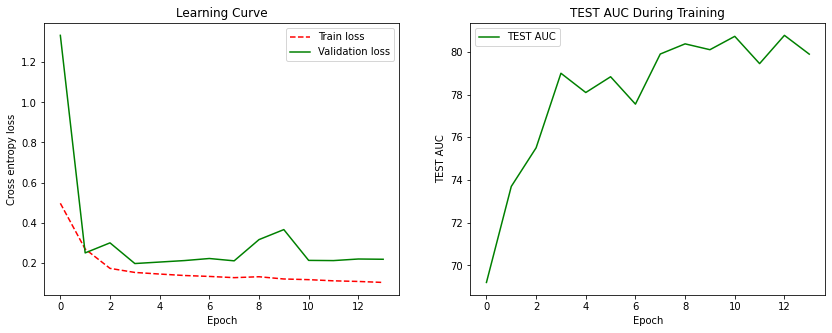


 Test AUC is 79.00046793619792 
 Validation Loss is 0.19632144997403084

 Test AUC in each class is:
(0, 70.80140485312899)
(1, 86.8733850129199)
(2, 83.20083833200839)
(3, 82.74342947511107)
(4, 72.42631467345207)
(5, 79.85454545454544)
(6, 82.20757825370674)
(7, 74.43407287157287)
(8, 74.18947368421053)
(9, 75.57445868316394)
(10, 85.52912756666358)
(11, 80.17100977198697)
Tox21 - Random Scaffold Split - Seed 213


In [ ]:
# split seed: 213
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

In [ ]:
def train_modelm(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        with torch.no_grad():
          model.eval() #Prepare model for evaluation
          
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
                mol_dgl_graph=mol_dgl_graph.to(device)
                labels=labels.to(device)
                masks=masks.to(device)
                fg=fg.to(device)
                prediction = model(mol_dgl_graph, fg)
                loss_val = my_loss(prediction, labels, masks)
                epoch_val_loss += loss_val.item()
          epoch_val_loss /= (len(val_set))
        
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            average += 100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu'))
            #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) #with pytorch-lightening
            #average += 100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) # with sk-learn
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, masks), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          a1 = prediction_all[:, i][masks_all[:,i]==1]
          a2 = labels_all[:, i][masks_all[:,i]==1]
          results.append(100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu')))
          #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
          #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
          average += results[i]

    print('\n Test AUC is', average.item()/12, '\n Validation Loss is', val_losses[-patience-1])
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs

In [ ]:
pos_weight = torch.ones((1,12))
pos_weight_val = torch.ones((1,12))

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install pytorch_lightning
    import pytorch_lightning as pl

from pytorch_lightning.metrics.classification import AUROC


def my_loss(output, label, mask=None):
    # criterion = torch.nn.BCELoss(reduction='none').to(device)
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight).to(device)
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
        # loss = torch.sum(torch.sum((weight_sum*criterion(output,label)), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
        # loss = torch.sum(torch.sum(mask*(weight_sum*criterion(output,label)), axis=1))
    return loss

def my_loss_val(output, label, mask=None):
    # criterion = torch.nn.BCELoss(reduction='none').to(device)
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight_val).to(device)
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
        # loss = torch.sum(torch.sum((weight_sum*criterion(output,label)), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
        # loss = torch.sum(torch.sum(mask*(weight_sum*criterion(output,label)), axis=1))
    return loss

def train_model_(model, batch_size, patience=10, n_epochs=2):
    metric = AUROC()
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    val_AUCs = []
    test_AUCs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # Initialize the early_stopping object
    start_time = time.time()

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() # Prepare model for training
        for i, (_, mol_dgl_graph, globals, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            globals=globals.to(device)
            prediction = model(mol_dgl_graph, globals)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
            # scheduler.step()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)
        #########################################################
        # Validation set
        model.eval() # Prepare model for evaluation
        metric = AUROC()  ## Pytorch_Lightening
        # metric = roc_auc_score ## Scikit-Learn
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, globals, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              globals=globals.to(device)
              prediction = model(mol_dgl_graph, globals)
              loss_val = my_loss_val(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
              prediction_sig=torch.nn.functional.sigmoid(prediction)
              prediction_all = torch.cat((prediction_all, prediction_sig), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
        average = torch.tensor([0.], device=device)
        list=[]
        for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            t = 100*metric(a1.view(-1), a2.view(-1).int()).item()
            list.append(t)
            average += t
        epoch_val_auc = average.item()/12
        val_AUCs.append(epoch_val_auc)
        epoch_val_loss /= (len(val_set))
        val_losses.append(epoch_val_loss)     

        #########################################################
        # Test set
        model.eval() 
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, globals, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              globals=globals.to(device)
              prediction = model(mol_dgl_graph, globals)
              prediction_sig=torch.nn.functional.sigmoid(prediction)
              prediction_all = torch.cat((prediction_all, prediction_sig), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, masks), 0)
        average = torch.tensor([0.], device=device)
        list=[]
        for i in range(12):
            a1 = prediction_all[:, i][masks_all[:,i]==1]
            a2 = labels_all[:, i][masks_all[:,i]==1]
            t = 100*metric(a1.view(-1), a2.view(-1).int()).item()
            list.append(t)
            average += t
        epoch_test_auc = average.item()/12
        test_AUCs.append(epoch_test_auc)

        ########################################################################
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        # early_stopping(epoch_val_auc, model)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break

        ########################################################################
        # Print
        epoch_len = len(str(n_epochs))
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_loss: {epoch_train_loss:.5f} ' +
                     f'Valid_loss: {epoch_val_loss:.5f} ' +
                     f'Valid_AUC: {epoch_val_auc:.5f} ' +
                     f'Test_AUC: {epoch_test_auc:.5f}')
           
   ############################################################################# 
    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) # Load the last checkpoint with the best model
    print('\n')
    # Draw Learning Curve
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Cross-Entropy-Loss and AUC-ROC"), plt.legend(loc="best")
    plt.show()

    print('\n')
    # Draw Learning Curve
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(val_AUCs)), val_AUCs, '--', color="orange",  label="Val AUC")
    plt.plot(range(len(test_AUCs)), test_AUCs, color="purple", label="Test AUC")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("AUC-ROC"), plt.legend(loc="best")
    plt.show()
    ############################################################################# 

    return  model, train_losses, val_losses

     |████████████████████████████████| 849kB 3.4MB/s 
     |████████████████████████████████| 829kB 8.8MB/s 
     |████████████████████████████████| 276kB 18.0MB/s 
     |████████████████████████████████| 184kB 18.5MB/s 
     |████████████████████████████████| 112kB 18.5MB/s 
     |████████████████████████████████| 1.3MB 18.9MB/s 
     |████████████████████████████████| 143kB 27.8MB/s 
     |████████████████████████████████| 296kB 26.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=f822792531374a2be7c32ad27a69a3bed9dfe4e825b122194468ccce213b6360
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=0983cf1a6d13c36bd6732010ddeab5cddf53b0ca4488afabd9c4a6ec0925ac6a
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future 

In [ ]:
print(DATA)

Tox21 - Random Scaffold Split - Seed 213


Validation loss decreased (inf --> 0.666024).  Saving model ...
[1/1] Train_loss: 0.75806 Valid_loss: 0.66602 Valid_AUC: 67.21887 Test_AUC: 66.09616

 Training Time was 12.015851974487305 seconds in cuda:0




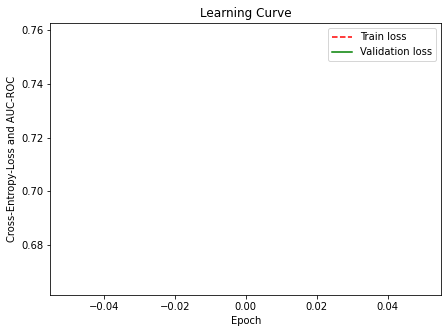

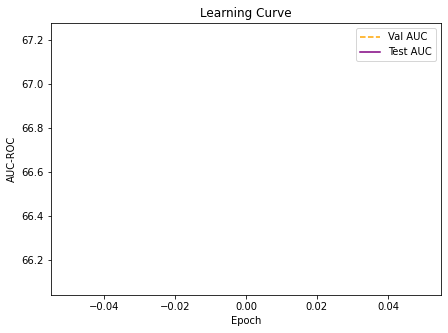

ValueError: ignored

In [ ]:
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
import random 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
dgl.seed(seed)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model_(model, batch_size=256, patience=10, n_epochs=1)

Validation loss decreased (inf --> 0.658629).  Saving model ...
[1/1] Train_loss: 0.75716 Valid_loss: 0.65863 Valid_AUC: 65.28660 Test_AUC: 64.41074

 Training Time was 12.056686162948608 seconds in cuda:0




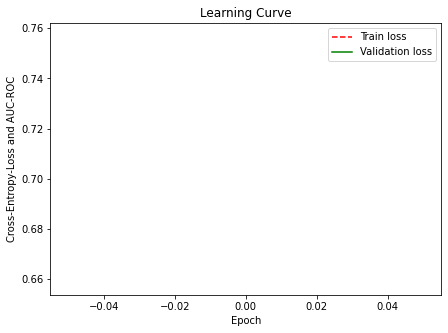

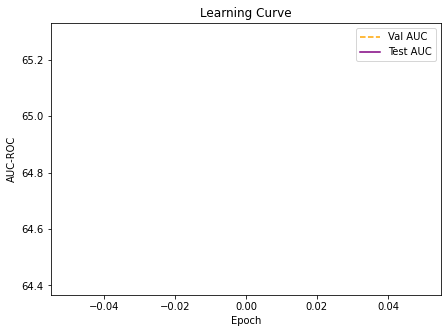

ValueError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=1)seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
import random 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
dgl.seed(seed)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model_(model, batch_size=256, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.62926 Valid_Loss: 0.55536 Test_AUC: 64.04779
Validation loss decreased (inf --> 0.555364).  Saving model ...

 Training Time was 12.219011545181274 seconds in cuda:0




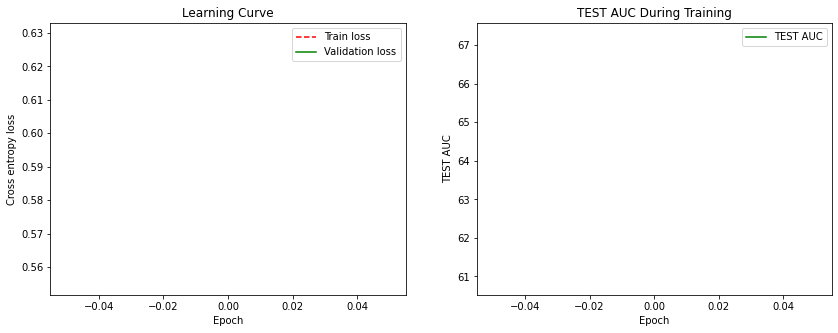

IndexError: ignored

In [ ]:
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
import random 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
dgl.seed(seed)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.62373 Valid_Loss: 0.55395 Test_AUC: 65.58364
Validation loss decreased (inf --> 0.553948).  Saving model ...

 Training Time was 12.22122311592102 seconds in cuda:0




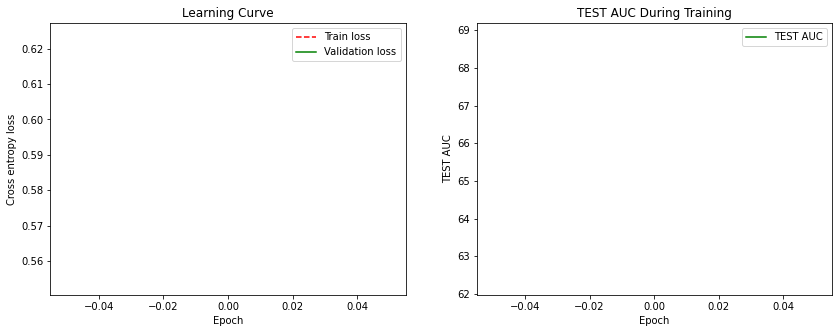

IndexError: ignored

In [ ]:
seed = 1
os.environ['PYTHONHASHSEED']=str(seed)
import random 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
dgl.seed(seed)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.62630 Valid_Loss: 0.52481 Test_AUC: 57.79636
Validation loss decreased (inf --> 0.524807).  Saving model ...

 Training Time was 12.16792368888855 seconds in cuda:0




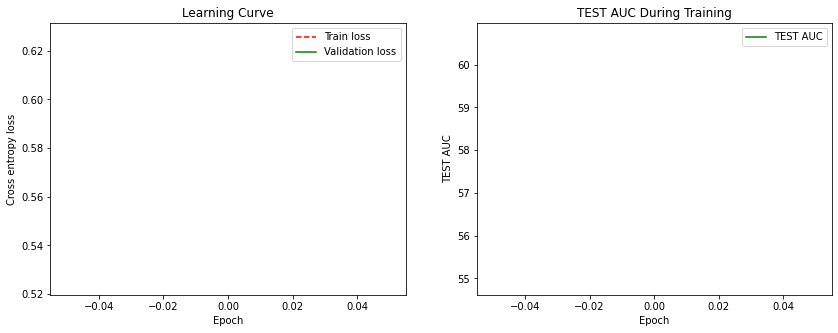

IndexError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.60320 Valid_Loss: 0.50683 Test_AUC: 62.28401
Validation loss decreased (inf --> 0.506832).  Saving model ...

 Training Time was 12.223082065582275 seconds in cuda:0




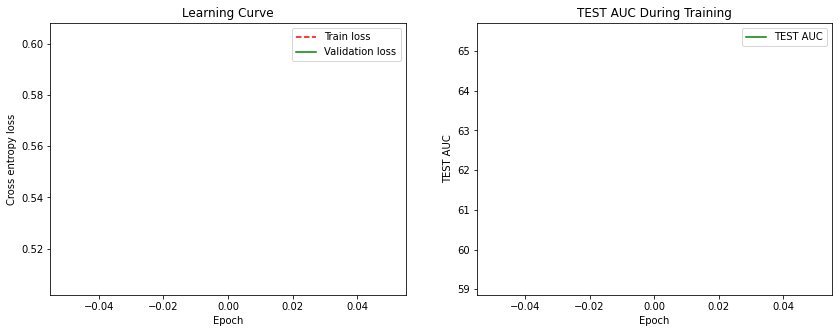

IndexError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.63027 Valid_Loss: 0.52818 Test_AUC: 60.40737
Validation loss decreased (inf --> 0.528182).  Saving model ...

 Training Time was 12.074568271636963 seconds in cuda:0




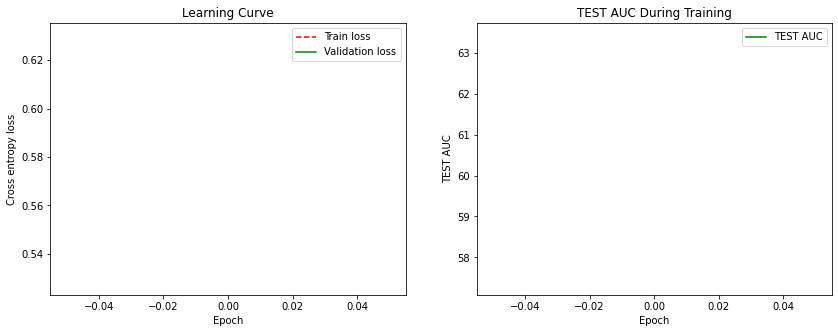

IndexError: ignored

In [ ]:

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.51067 Valid_Loss: 0.46420 Test_AUC: 73.04634
Validation loss decreased (inf --> 0.464196).  Saving model ...

 Training Time was 17.52387762069702 seconds in cuda:0




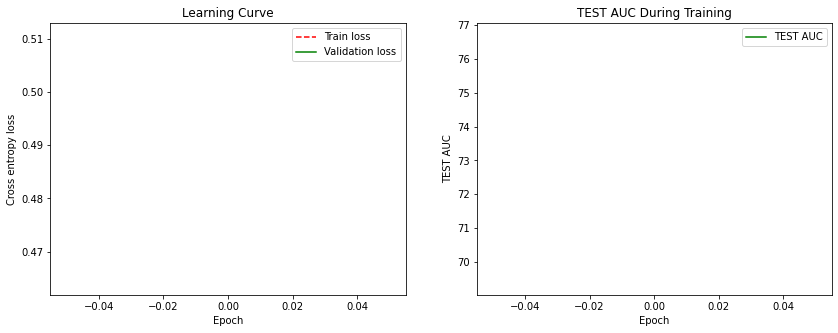

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  
  #dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.51218 Valid_Loss: 0.47324 Test_AUC: 73.98975
Validation loss decreased (inf --> 0.473241).  Saving model ...

 Training Time was 17.53179430961609 seconds in cuda:0




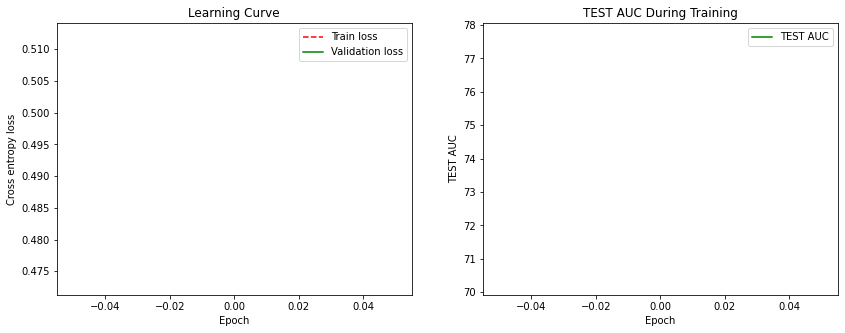

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
  
  #dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.51207 Valid_Loss: 0.47879 Test_AUC: 71.09366
Validation loss decreased (inf --> 0.478791).  Saving model ...

 Training Time was 17.868377685546875 seconds in cuda:0




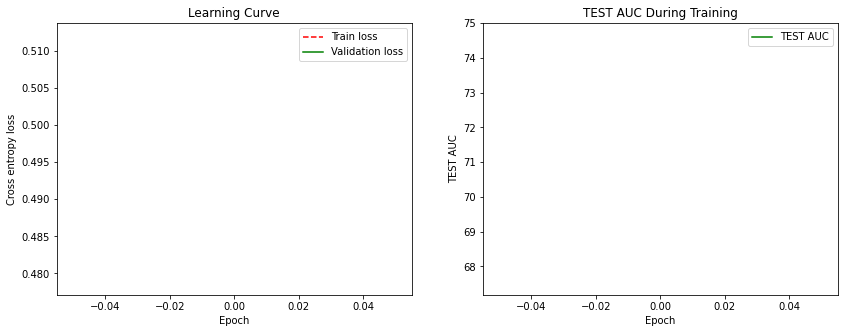

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   torch.cuda.manual_seed(seed_value)
#   torch.cuda.manual_seed_all(seed_value) # gpu vars
#   torch.backends.cudnn.deterministic = True  #needed
#   torch.backends.cudnn.benchmark = False
  
  #dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.51175 Valid_Loss: 0.45912 Test_AUC: 71.42711
Validation loss decreased (inf --> 0.459121).  Saving model ...

 Training Time was 17.427518844604492 seconds in cuda:0




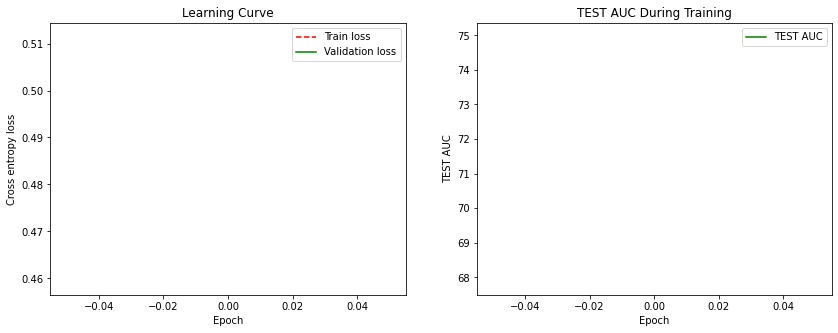

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device == 'cuda:0':
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False
  
  #dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

In [ ]:
if device == 'cuda:0':
  print(1)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value) # gpu vars
  torch.backends.cudnn.deterministic = True  #needed
  torch.backends.cudnn.benchmark = False

1


[1/1] Train_Loss: 0.51211 Valid_Loss: 0.66366 Test_AUC: 71.45076
Validation loss decreased (inf --> 0.663660).  Saving model ...

 Training Time was 18.29956293106079 seconds in cuda:0




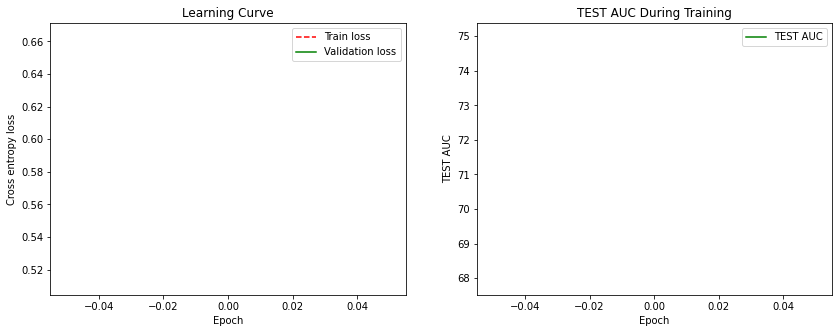

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

model1 = GNN().to(device)

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

model2 = GNN().to(device)

In [ ]:
# for comparing initialization
p1 = []
p2 = []
for parameter in model1.parameters():
  p1.append(parameter)
for parameter in model2.parameters():
  p2.append(parameter)

j = 0
for i in range(len(p1)):
  if torch.equal(p1[i],p2[i]) != True:
    print(i, '\nModels are not equal')
    j = 1
    break
if j !=1: print('Models are equal')

Models are equal


[ 18/200] Train_Loss: 0.09926 Valid_Loss: 0.19639 Test_AUC: 81.20865
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 325.724880695343 seconds in cuda:0




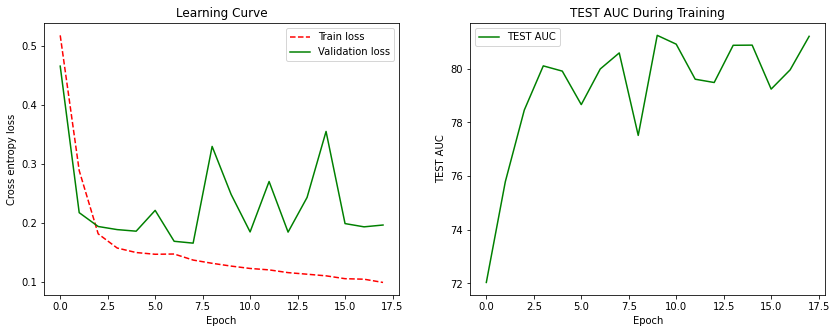


 Test AUC is 80.58969624837239 
 Validation Loss is 0.16574360142874686

 Test AUC in each class is:
(0, 78.9086127547666)
(1, 82.62757871878394)
(2, 83.32041410435292)
(3, 81.6694841686846)
(4, 76.26091225374057)
(5, 85.30028363546677)
(6, 78.5061969993477)
(7, 70.0679012345679)
(8, 79.84189723320159)
(9, 86.22723894463024)
(10, 87.02762722071665)
(11, 77.31815803244373)


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

model1.to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model1, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[2/2] Train_Loss: 0.13809 Valid_Loss: 0.17184 Test_AUC: 79.91351
Validation loss decreased (0.183830 --> 0.171836).  Saving model ...

 Training Time was 36.412604570388794 seconds in cuda:0




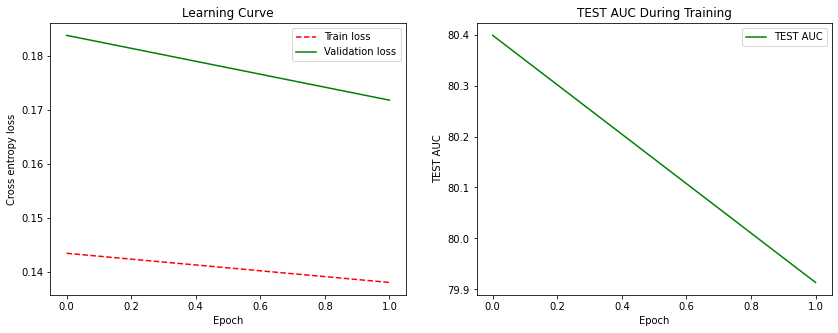

IndexError: ignored

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)


model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model2, batch_size=32, optimizer=optimizer, patience=10, n_epochs=2)

[2/2] Train_Loss: 0.12579 Valid_Loss: 0.17958 Test_AUC: 78.42233
Validation loss decreased (0.197752 --> 0.179581).  Saving model ...

 Training Time was 36.469813108444214 seconds in cuda:0




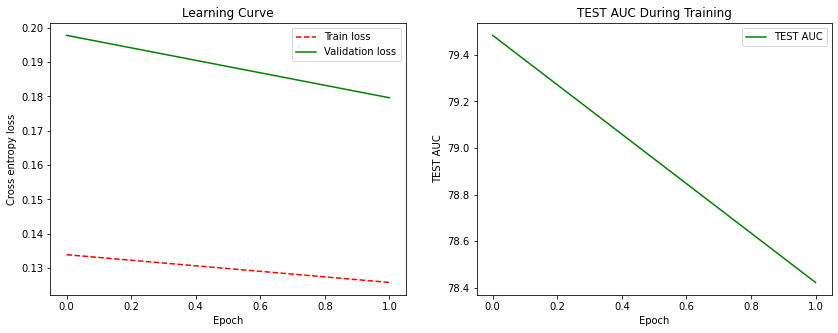

IndexError: ignored

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model2, batch_size=32, optimizer=optimizer, patience=10, n_epochs=2)

In [ ]:
print(p1[0],p2[0])

Parameter containing:
tensor([[ 0.1141,  0.0808, -0.0059,  ..., -0.1133, -0.1343,  0.1078],
        [-0.0769, -0.0278, -0.0681,  ..., -0.1467, -0.0105, -0.1339],
        [ 0.1140,  0.0140,  0.0942,  ...,  0.1068,  0.0202, -0.0355],
        ...,
        [ 0.2454,  0.1169,  0.0481,  ...,  0.0052, -0.0373, -0.1527],
        [-0.0382,  0.0609,  0.0126,  ..., -0.1035,  0.1301,  0.0494],
        [-0.1832,  0.0057, -0.0445,  ...,  0.0124, -0.1661,  0.0393]],
       device='cuda:0', requires_grad=True) Parameter containing:
tensor([[ 0.1141,  0.0808, -0.0059,  ..., -0.1133, -0.1343,  0.1078],
        [-0.0769, -0.0278, -0.0681,  ..., -0.1467, -0.0105, -0.1339],
        [ 0.1140,  0.0140,  0.0942,  ...,  0.1068,  0.0202, -0.0355],
        ...,
        [ 0.2454,  0.1169,  0.0481,  ...,  0.0052, -0.0373, -0.1527],
        [-0.0382,  0.0609,  0.0126,  ..., -0.1035,  0.1301,  0.0494],
        [-0.1832,  0.0057, -0.0445,  ...,  0.0124, -0.1661,  0.0393]],
       device='cuda:0', requires_grad=True)


[1/1] Train_Loss: 0.51324 Valid_Loss: 0.61976 Test_AUC: 68.84049
Validation loss decreased (inf --> 0.619760).  Saving model ...

 Training Time was 21.08390736579895 seconds in cuda:0




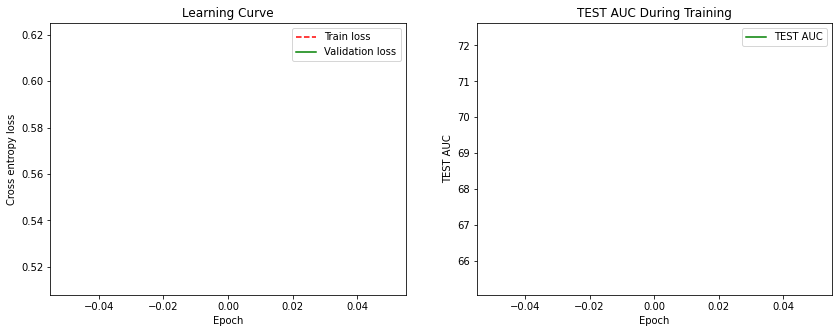

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.51022 Valid_Loss: 0.42070 Test_AUC: 70.93926
Validation loss decreased (inf --> 0.420697).  Saving model ...

 Training Time was 17.842329263687134 seconds in cuda:0




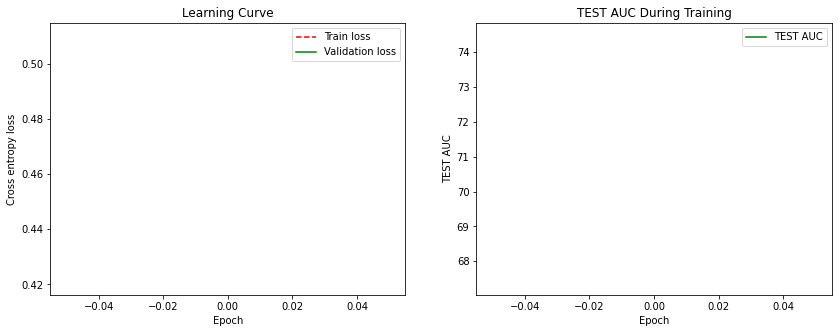

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.50998 Valid_Loss: 0.52430 Test_AUC: 71.20543
Validation loss decreased (inf --> 0.524296).  Saving model ...

 Training Time was 120.35789394378662 seconds in cpu




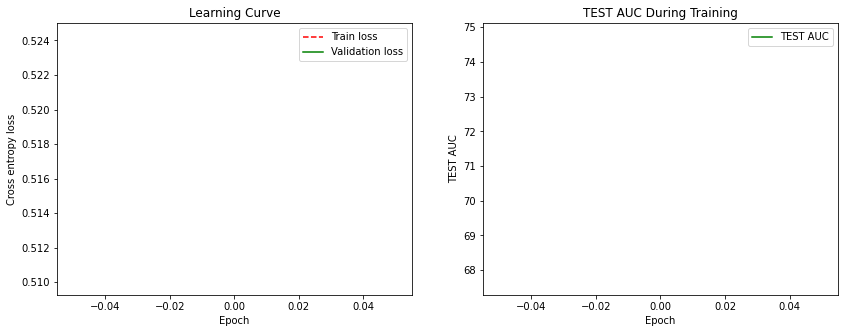

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

[1/1] Train_Loss: 0.50998 Valid_Loss: 0.52430 Test_AUC: 71.20543
Validation loss decreased (inf --> 0.524296).  Saving model ...

 Training Time was 117.57479000091553 seconds in cpu




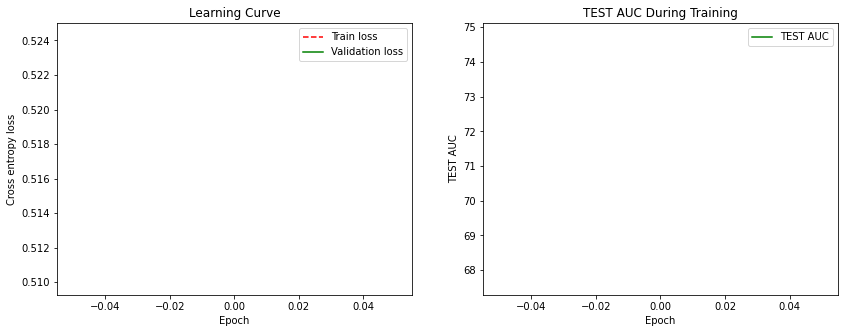

IndexError: ignored

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=1)

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

model1 = GNN().to(device)

In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

model2 = GNN().to(device)

In [ ]:
# for comparing initialization
p1 = []
p2 = []
for parameter in model1.parameters():
  p1.append(parameter)
for parameter in model2.parameters():
  p2.append(parameter)

j = 0
for i in range(len(p1)):
  if torch.equal(p1[i],p2[i]) != True:
    print(i, '\nModels are not equal')
    j = 1
    break
if j !=1: print('Models are equal')

Models are equal


In [ ]:

for i in range(len(p1)):
  if torch.equal(p1[i],p2[i]):
    break
    print(i)
  print('Models are equal')

In [ ]:
model1.parameters == model2.parameters

False

In [ ]:
len(p2)

118

In [ ]:
torch.equal(p1[0],p2[0])

True

In [ ]:
parameter

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], requires_grad=True)

In [ ]:
model1.state_dict == model2.state_dict

False

In [ ]:
model1.GNN1.linear_0_e.weight

Parameter containing:
tensor([[-0.0050,  0.0098, -0.0687,  ..., -0.0325,  0.0264, -0.0566],
        [ 0.0612,  0.0687,  0.0843,  ..., -0.0004,  0.0542, -0.0827],
        [-0.0047,  0.0508, -0.0803,  ...,  0.0629,  0.0199, -0.0603],
        ...,
        [-0.0896, -0.0035, -0.1228,  ...,  0.0480,  0.1370,  0.1358],
        [-0.0991, -0.0498, -0.0031,  ..., -0.0240,  0.1117, -0.0030],
        [ 0.1508,  0.0137,  0.0417,  ..., -0.0197, -0.0883,  0.0298]],
       requires_grad=True)

In [ ]:
model2.GNN1.linear_0_e.weight

Parameter containing:
tensor([[-0.0050,  0.0098, -0.0687,  ..., -0.0325,  0.0264, -0.0566],
        [ 0.0612,  0.0687,  0.0843,  ..., -0.0004,  0.0542, -0.0827],
        [-0.0047,  0.0508, -0.0803,  ...,  0.0629,  0.0199, -0.0603],
        ...,
        [-0.0896, -0.0035, -0.1228,  ...,  0.0480,  0.1370,  0.1358],
        [-0.0991, -0.0498, -0.0031,  ..., -0.0240,  0.1117, -0.0030],
        [ 0.1508,  0.0137,  0.0417,  ..., -0.0197, -0.0883,  0.0298]],
       requires_grad=True)

[ 15/200] Train_Loss: 0.10810 Valid_Loss: 0.19906 Test_AUC: 80.06384
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 481.6234438419342 seconds in cuda:0




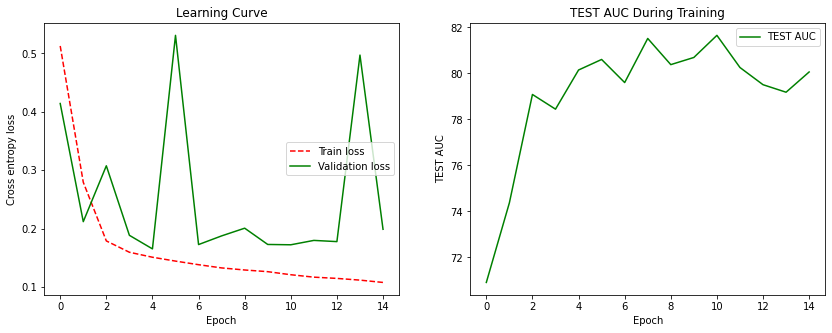


 Test AUC is 80.1493428548177 
 Validation Loss is 0.1655322837037906

 Test AUC in each class is:
(0, 76.28862590401052)
(1, 78.71384858355543)
(2, 82.99484953404647)
(3, 81.17604057202905)
(4, 74.97812213186485)
(5, 82.65815760266372)
(6, 85.60828440965426)
(7, 73.27366255144032)
(8, 79.59815546772069)
(9, 86.67316982534375)
(10, 84.63565191207468)
(11, 75.19361590790162)
Tox21 - Random Scaffold Split - Seed 50


In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 16/200] Train_Loss: 0.11219 Valid_Loss: 1.31327 Test_AUC: 74.17560
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 514.445858001709 seconds in cuda:0




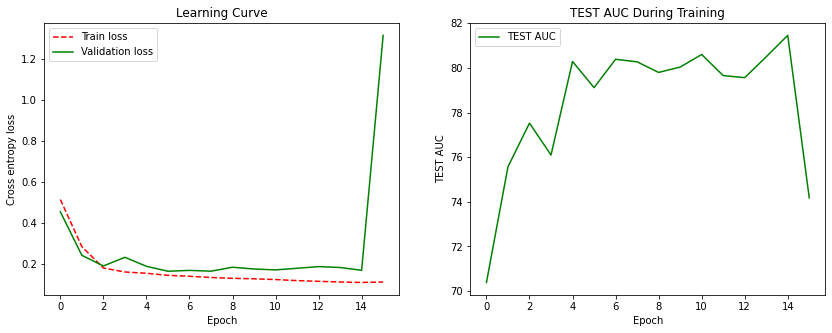


 Test AUC is 79.11342875162761 
 Validation Loss is 0.1647122929379401

 Test AUC in each class is:
(0, 74.8586456278764)
(1, 81.54180238870794)
(2, 82.54870549325615)
(3, 81.22172979394162)
(4, 77.65255810975219)
(5, 84.38771735109137)
(6, 75.513698630137)
(7, 69.34979423868313)
(8, 75.71805006587616)
(9, 84.24377554812338)
(10, 84.53026196928637)
(11, 77.79434850863423)
Tox21 - Random Scaffold Split - Seed 50


In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

[ 26/200] Train_Loss: 0.07634 Valid_Loss: 0.30627 Test_AUC: 82.48736
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 830.3700864315033 seconds in cuda:0




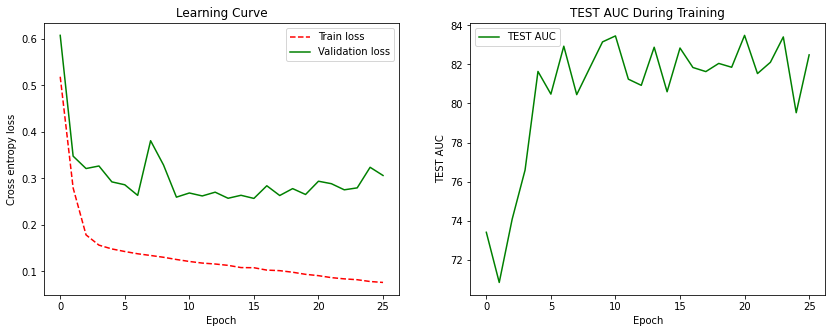


 Test AUC is 82.83887227376302 
 Validation Loss is 0.25695891017962535

 Test AUC in each class is:
(0, 91.5610799251537)
(1, 96.33220910623945)
(2, 86.79892567765816)
(3, 79.9127640036731)
(4, 76.44589644589644)
(5, 83.44827586206897)
(6, 78.47963621984975)
(7, 75.37707390648566)
(8, 78.48749370488501)
(9, 81.04838709677419)
(10, 88.92560198682648)
(11, 77.24914897065976)
Tox21 - Random Scaffold Split - Seed 50


In [ ]:
# split seed: 50
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

In [ ]:
model8283 = model

In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_1372_8139_2.pt  tox21_213_7960.pt    tox21_50_8207_2.pt
tox21_1372_8139.pt    tox21_213_8099_2.pt  tox21_50_8207.pt
tox21_213_7960_2.pt   tox21_213_8099.pt


In [ ]:
save_path1="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_50_8283.pt"
save_path2="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_50_8283_2.pt"
torch.save(model8283, save_path1)
torch.save(model8283.state_dict(), save_path2)
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_1372_8139_2.pt  tox21_213_7960.pt    tox21_50_8207_2.pt  tox21_50_8283.pt
tox21_1372_8139.pt    tox21_213_8099_2.pt  tox21_50_8207.pt
tox21_213_7960_2.pt   tox21_213_8099.pt    tox21_50_8283_2.pt


[ 14/200] Train_Loss: 0.10146 Valid_Loss: 0.25205 Test_AUC: 82.65718
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 233.96694374084473 seconds in cuda:0




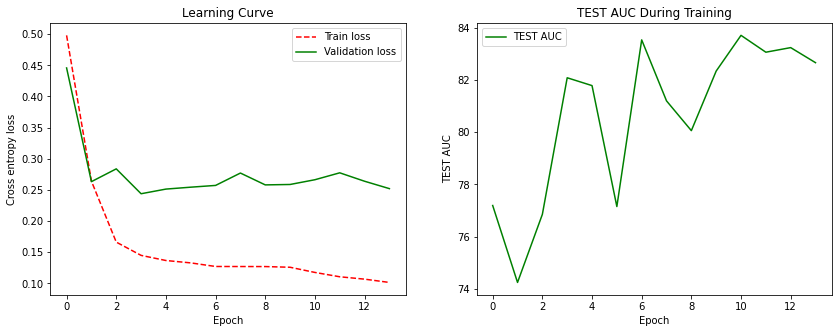


 Test AUC is 82.07913208007812 
 Validation Loss is 0.24385545080192245

 Test AUC in each class is:
(0, 92.45656241646618)
(1, 94.41237514593332)
(2, 89.08524612363735)
(3, 76.46464646464646)
(4, 74.94109494109496)
(5, 82.1951219512195)
(6, 70.68999604586794)
(7, 76.93721719457014)
(8, 84.96726540204801)
(9, 78.99769585253456)
(10, 86.61267681675847)
(11, 77.18971200086453)
Tox21 - Random Scaffold Split - Seed 50


In [ ]:
# split seed: 50
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
print(DATA)

In [ ]:
results = np.array([81.39961751302083, 80.99319458007812, 82.07913208007812])
print(results.mean(),results.var())


81.49064805772569 0.20068665568567381


In [ ]:
model8207 = model

In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_1372_8139_2.pt  tox21_213_7960_2.pt  tox21_213_8099_2.pt
tox21_1372_8139.pt    tox21_213_7960.pt    tox21_213_8099.pt


In [ ]:
save_path1="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_50_8207.pt"
save_path2="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_50_8207_2.pt"
torch.save(model8207, save_path1)
torch.save(model8207.state_dict(), save_path2)
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_1372_8139_2.pt  tox21_213_7960.pt    tox21_50_8207_2.pt
tox21_1372_8139.pt    tox21_213_8099_2.pt  tox21_50_8207.pt
tox21_213_7960_2.pt   tox21_213_8099.pt


[ 15/200] Train_Loss: 0.09441 Valid_Loss: 0.20919 Test_AUC: 81.56078
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 256.2275743484497 seconds in cuda:0




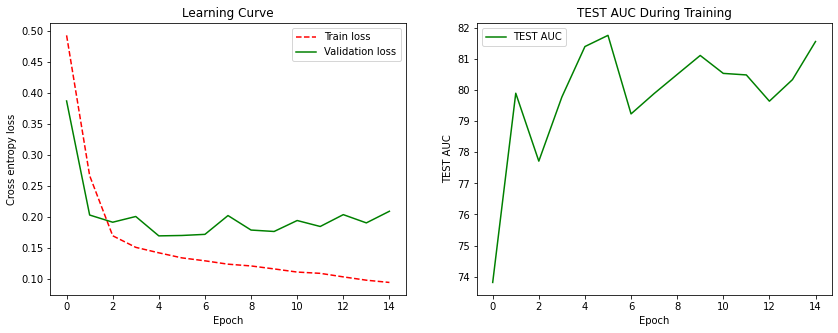


 Test AUC is 81.39961751302083 
 Validation Loss is 0.16949379337549514

 Test AUC in each class is:
(0, 76.65351742274818)
(1, 83.47645839502518)
(2, 85.2427953766386)
(3, 81.60551925800704)
(4, 79.40492198672386)
(5, 88.70082624244667)
(6, 80.19406392694064)
(7, 72.1604938271605)
(8, 76.6403162055336)
(9, 85.94388703084356)
(10, 86.47433002107798)
(11, 80.29827315541601)


In [ ]:
# split seed: 1372
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
# if device == 'cuda:0':
#   dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM_M5(135,12,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        #self.GNN2 = DGM_M5(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
model8139 = model

In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_213_7960_2.pt  tox21_213_7960.pt	tox21_213_8099_2.pt  tox21_213_8099.pt


In [ ]:
save_path1="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_1372_8139.pt"
save_path2="/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_1372_8139_2.pt"
torch.save(model8139, save_path1)
torch.save(model8139.state_dict(), save_path2)
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_1372_8139_2.pt  tox21_213_7960_2.pt  tox21_213_8099_2.pt
tox21_1372_8139.pt    tox21_213_7960.pt    tox21_213_8099.pt


In [ ]:
!ls '/content/drive/MyDrive/GMLG_Research/Saved_Models/'

tox21_213_7960_2.pt  tox21_213_7960.pt	tox21_213_8099_2.pt  tox21_213_8099.pt


In [ ]:
mx = torch.load( '/content/drive/MyDrive/GMLG_Research/Saved_Models/tox21_213_8099.pt', map_location=torch.device(device))

In [ ]:
mx

GNN(
  (GNN1): DGM_M5(
    (linear_0_v): Linear(in_features=135, out_features=300, bias=True)
    (bn_0_v): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_e): Linear(in_features=282, out_features=300, bias=True)
    (bn_0_e): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_0_g): Linear(in_features=200, out_features=300, bias=True)
    (bn_0_g): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_0): Linear(in_features=1500, out_features=300, bias=True)
    (bn_e_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_e_1): Linear(in_features=300, out_features=300, bias=True)
    (bn_e_1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_m_0): Linear(in_features=600, out_features=300, bias=False)
    (bn_m_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
        
        with torch.no_grad():      
            metric = roc_auc_score
            _, _, test_dataloader = loader(512)
            prediction_all= torch.empty(0, device=device)
            labels_all= torch.empty(0, device=device)
            masks_all= torch.empty(0, device=device)
            for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
                mol_dgl_graph=mol_dgl_graph.to(device)
                labels=labels.to(device)
                masks=masks.to(device)
                fg=fg.to(device)
                prediction = mx(mol_dgl_graph, fg)
                prediction_all = torch.cat((prediction_all, prediction), 0)
                labels_all = torch.cat((labels_all, labels), 0)
                masks_all = torch.cat((masks_all, masks), 0)
            results = []
            average = torch.tensor([0.], device=device)
            for i in range(12):
              a1 = prediction_all[:, i][masks_all[:,i]==1]
              a2 = labels_all[:, i][masks_all[:,i]==1]
              results.append(100*metric(a2.view(-1).int().to('cpu'), a1.view(-1).to('cpu')))
              #average += 100*metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) # with pytorch-lightening
              #results.append(100*metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))) # with sk-learn
              average += results[i]
            print('Test AUC on Seed 213 is', average.item()/12)


Test AUC on Seed 213 is 80.99319458007812
